# TIME SERIES REGRESSION FAVORITA

In this project I will be assuming a role of a data scientist in Corporation Favorita, a large Ecuadorian-based grocery retailer. Corporation Favorita wants to ensure that they always have the right quantity of products in stock. To do this i have decided to build a series of machine learning models to forecast the demand of products in various locations. The marketing and sales team have provided some data to aid this endeavor. I will be using CRISP-DM Framework for this project.

## Business Understanding

It has always been a problem for companies to determine the right level of stock to have. There are a lot of factors to consider when it comes to stocking: lead times, cost of transportation, cost of warehousing, product lifespan and others.

Company's want to know the best level of stock to have in order to be able to satisfy customers demand whilst spend the lease possible amount on the stock.

Stock is company resources (money) held up, it is therefore prudent to be able to determine the right level of stock to hold. Policies like JIT(Just in time) and EOQ(Economic order quantities) have been utilised to manage stock levels.

Overstocking can lead to: locked up funds that could be used for other projects, expiry of goods, large/special warehouse spaces (which is costly), retailers like Favorita sometimes have to reduce prices of near-expiry products to cut down on losses. Some dangers of under-stocking could include disatisfied customers (which may lead to them voting with their feet), decrease in revenue, companies may also end up spending more on logistics when they understock frequently.

In this project we will be using machine learning and regression models to forecast sales which would help us determine stock levels to hold, the company believes this would be a more accurate policy since it is based on a large dataset of previous sales.

## Research questions

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Did the earthquake impact sales?
4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?
7. Which product family and stores did the promotions affect.
8. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
9. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.
10. Compare the sales for each month across the years and determine which month of which year had the highest sales.

## Hypothesis

Null Hypothesis (H0): "There is no significant relationship between store sales and products promotions."

Alternative Hypothesis (Ha): "There is a significant relationship between store sales and products promotions."

In [1]:
#Data extraction and manipulation

import pyodbc    
from dotenv import dotenv_values
import pandas as pd
from itertools import product
import numpy as np


#Visualization and modelling
import matplotlib.dates as mdates
import calplot
from statsmodels.tsa.seasonal import seasonal_decompose
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
#Utilities
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OneHotEncoder
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import ttest_ind
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor


from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
import itertools
import warnings 
warnings.filterwarnings('ignore')
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER_NAME")
database = environment_variables.get("DATABASE_NAME")
username = environment_variables.get("USER")
password = environment_variables.get("PASSWORD")

In [3]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"


In [4]:

# Use the connect method of the pyodbc library and pass in the connection string.
connection = pyodbc.connect(connection_string)

In [5]:
# Sql query to retrieve data from Microsoft SQL database
oil_df = "SELECT * FROM dbo.oil"
#Execute the SQL queries and load the results into Pandas DataFrames
oil_df = pd.read_sql(oil_df, connection)
#Show retrieved table
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [6]:
# Sql query to retrieve data from Microsoft SQL database
holiday_events_df = "SELECT * FROM dbo.holidays_events"
#Execute the SQL queries and load the results into Pandas DataFrames
holiday_events_df = pd.read_sql(holiday_events_df, connection)
#Show retrieved table
holiday_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
# Sql query to retrieve data from Microsoft SQL database
store = "SELECT * FROM dbo.stores"
#Execute the SQL queries and load the results into Pandas DataFrames
store = pd.read_sql(store, connection)
#Show retrieved table
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
# close connection
connection.close()


In [9]:
train_df = pd.read_csv(r'C:\Users\User\Desktop\Azubi_Projects\TIME-SERIES-REGRESSION\Data\train.csv')

train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Exploratory Data Analysis


### Train Data Exploration


In [10]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [11]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0


In [12]:
train_df.shape

(3000888, 6)

In [13]:
#Check unique observations 
train_df.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

In [14]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [15]:
train_df.duplicated().sum()

0

In [16]:
train_df['id'].unique().shape

(3000888,)

In [17]:
# Drop the id feature because it is not relevant to our analysis
train_df.drop(['id'],axis = 1, inplace=True)

In [18]:
train_df.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [19]:
# Change the dtype of the date column to a datetime
train_df['date'] = pd.to_datetime(train_df['date'])

In [20]:
# set the date columnas an index for better time series analysis
train_df.set_index('date').head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


### Check for completeness of data or missing values

In [21]:
train_df['date'].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-06 00:00:00', '2017-08-07 00:00:00', '2017-08-08 00:00:00',
 '2017-08-09 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-12 00:00:00', '2017-08-13 00:00:00', '2017-08-14 00:00:00',
 '2017-08-15 00:00:00']
Length: 1684, dtype: datetime64[ns]

In [22]:
# Check for the erliest and lates date
actual_date = train_df['date'].min(),train_df['date'].max()
print(f' Start date:{actual_date[0]}\n End date: {actual_date[1]}')

 Start date:2013-01-01 00:00:00
 End date: 2017-08-15 00:00:00


In [23]:
date_range = pd.date_range(start = train_df['date'].min(), end = train_df['date'].max(), freq = 'D')
date_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [24]:
#The date_range for the start and end date is supposed to be 
date_range.size

1688

In [25]:
train_df['date'].unique().shape

(1684,)

In [26]:
# Find the missing days from date column of the train_df by using the differncr dates
missing_days = date_range.difference(train_df['date'])
missing_days

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

### Fill in values for the missing date by the family category

In [27]:
families = train_df['family'].unique()
print(f'Unique families in the train data is {families.size}')
families

Unique families in the train data is 33


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [28]:
#Check for the number of stores available
store_nbr = train_df['store_nbr'].unique()
print(f'Unique stores in train data is {store_nbr.size}')
store_nbr

Unique stores in train data is 54


array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)


### Key Insights on data completeness

1. There are no duplicates or null values in the train data
2. The date range between the start and end date is 1688 days, but there are only 1684 days in date column of train data
3. If there are only 1684 unique days in the train data, but the range difference between the first date and the last date is 1688, then it only stands that 4 days are missing
4. We need to add these 4 days to the dataframe and fill?interpolate the sales values for these 4 missing days.Because the sales for any given day is categorized into 
 - Families
 - Days 
 - Store_nbr
 

### Action Plan


1. Create the families for these 4 days for
2. Since there are 33 families, 54 stores and 4 missing dates, we will generate 7,128 new datapoints
 - 33x54x4(see unique values of these columns below)
 - Use the products class from itertools
  

### Create new data points for the missing dates

In [29]:

missing_data_points = product(missing_days, store_nbr, families)

# Create a dataframe from the product object generated
new_data = pd.DataFrame(data=missing_data_points, columns=["date", "store_nbr", "family"])
new_data.head()


,date,store_nbr,family
0,2013-12-25,1,AUTOMOTIVE
1,2013-12-25,1,BABY CARE
2,2013-12-25,1,BEAUTY
3,2013-12-25,1,BEVERAGES
4,2013-12-25,1,BOOKS


In [30]:
# Adding the new data to the original train data
# Note this introduces NaN in the sales and onpromotion columns
df = pd.concat([train_df,new_data],axis = 0)
df.set_index('date',inplace= True)
df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0
2013-01-01,1,BABY CARE,0.0,0.0
2013-01-01,1,BEAUTY,0.0,0.0
2013-01-01,1,BEVERAGES,0.0,0.0
2013-01-01,1,BOOKS,0.0,0.0
...,...,...,...,...
2016-12-25,9,POULTRY,NaN,NaN
2016-12-25,9,PREPARED FOODS,NaN,NaN
2016-12-25,9,PRODUCE,NaN,NaN


In [31]:
# Check null values again and the new generated data points should have the sales and onpromotion columns having null values
df.isna().sum()

store_nbr         0
family            0
sales          7128
onpromotion    7128
dtype: int64

In [32]:
# Double check to make sure there are no missing values
missing_days = set(date_range) - set(df.index.unique())
missing_days

set()

In [33]:
# Lets check the size again
df.shape 

(3008016, 4)

In [34]:
# Change NaN values for the salesand onpromotion columns to 0
df['sales'] = df['sales'].fillna(0)
df['onpromotion'] = df['onpromotion'].fillna(0)

In [35]:
df.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [36]:
# Sort date columns to be in acsending order from start date to end date(end date is 15th august 2017)
df.sort_index(inplace = True)
df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0.0
2013-01-01,42,CELEBRATION,0.000,0.0
2013-01-01,42,BREAD/BAKERY,0.000,0.0
2013-01-01,42,BOOKS,0.000,0.0
2013-01-01,42,BEVERAGES,0.000,0.0
...,...,...,...,...
2017-08-15,25,POULTRY,172.517,0.0
2017-08-15,25,PLAYERS AND ELECTRONICS,3.000,0.0
2017-08-15,25,PET SUPPLIES,3.000,0.0


### To note after making sure there are no missing dates

### Univeriate Analysis

1. Data set completed with 3,008,016 records 
2. The sales and onpromotion columns that was added from the new data points that was generated is all NaN which we are going ton fill with 0.

In [37]:
# Print unique values for each column
for column in df.columns:
    print(f'Column Name: {column}\n')
    print(f'Number of unique values: {df[column].unique().size}\n')
    print(f'{df[column].unique()}')
    print('%' * 80)

Column Name: store_nbr

Number of unique values: 54

[ 1 42 41 43 40  4 45 44 46 36 35 37 34 39 38 54  6 53 52  9  8  7 48 49
 47 51 50  5 33 18 17 19 16 15 20  2 21 11 10 12 14 13  3 29 30 28 32 31
 23 24 22 27 26 25]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Column Name: family

Number of unique values: 33

['AUTOMOTIVE' 'CELEBRATION' 'BREAD/BAKERY' 'BOOKS' 'BEVERAGES' 'BEAUTY'
 'BABY CARE' 'SEAFOOD' 'SCHOOL AND OFFICE SUPPLIES' 'PRODUCE'
 'PREPARED FOODS' 'POULTRY' 'PLAYERS AND ELECTRONICS' 'PET SUPPLIES'
 'PERSONAL CARE' 'MEATS' 'MAGAZINES' 'LIQUOR,WINE,BEER' 'LINGERIE'
 'LAWN AND GARDEN' 'LADIESWEAR' 'HOME CARE' 'HOME APPLIANCES' 'CLEANING'
 'DAIRY' 'DELI' 'EGGS' 'HOME AND KITCHEN II' 'HOME AND KITCHEN I'
 'HARDWARE' 'GROCERY II' 'GROCERY I' 'FROZEN FOODS']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Column Name: sales

Number of unique values: 379610

[   0.      15.     700.    ...  382.93   385.94  1269

In [38]:
# Change the format of the sales column from scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [39]:
# Assuming your DataFrame is named df
df.drop('family', axis=1).skew().rename('Skewness').reset_index()

,index,Skewness
0,store_nbr,0.00
1,sales,7.37
2,onpromotion,11.18


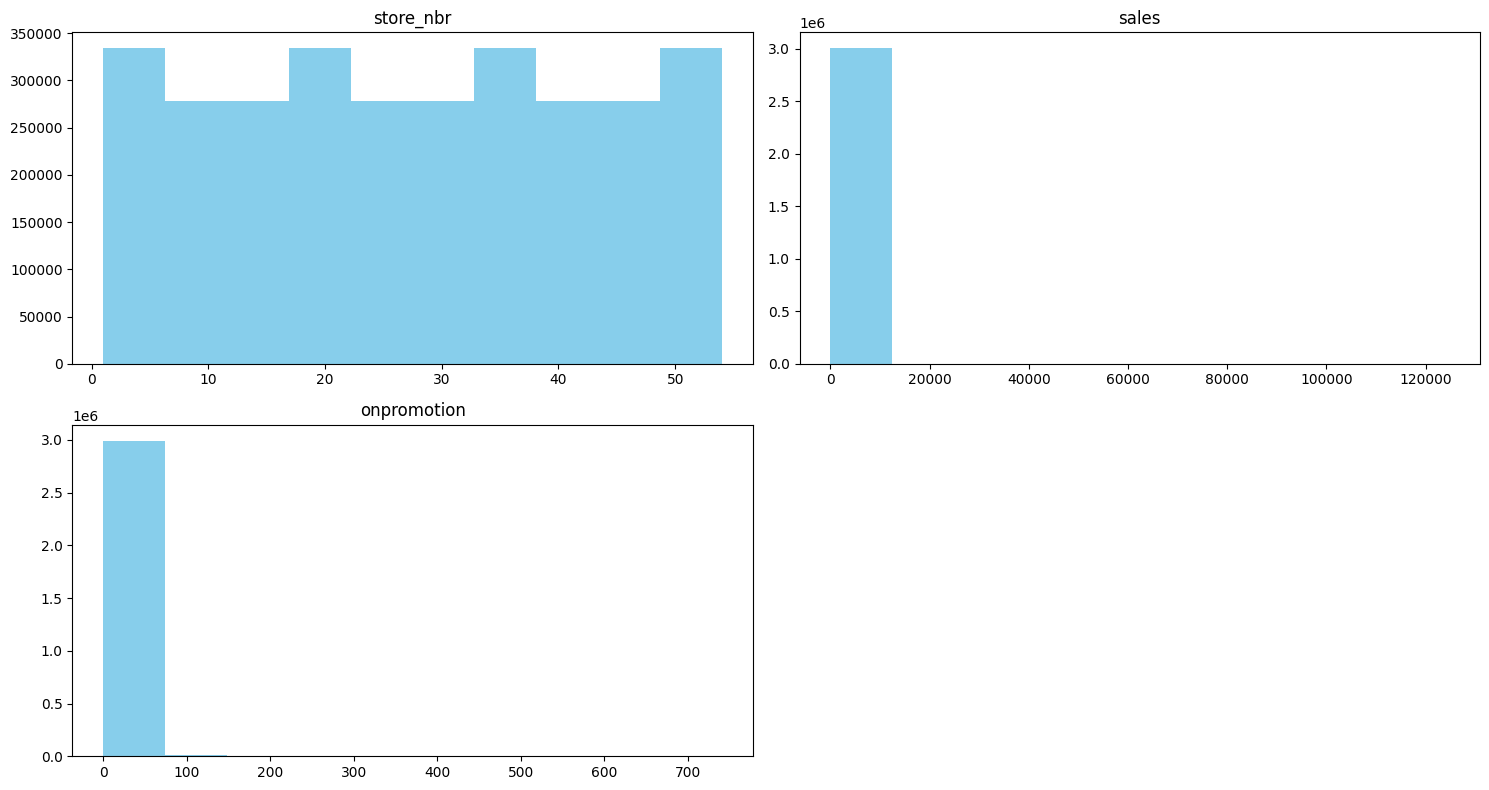

In [40]:
df.hist(figsize = (15,8), color = 'skyblue',grid= False)
plt.tight_layout()
plt.show()


In [41]:

df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00
2013-01-01,42,CELEBRATION,0.00,0.00
2013-01-01,42,BREAD/BAKERY,0.00,0.00
2013-01-01,42,BOOKS,0.00,0.00
2013-01-01,42,BEVERAGES,0.00,0.00
...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00
2017-08-15,25,PET SUPPLIES,3.00,0.00


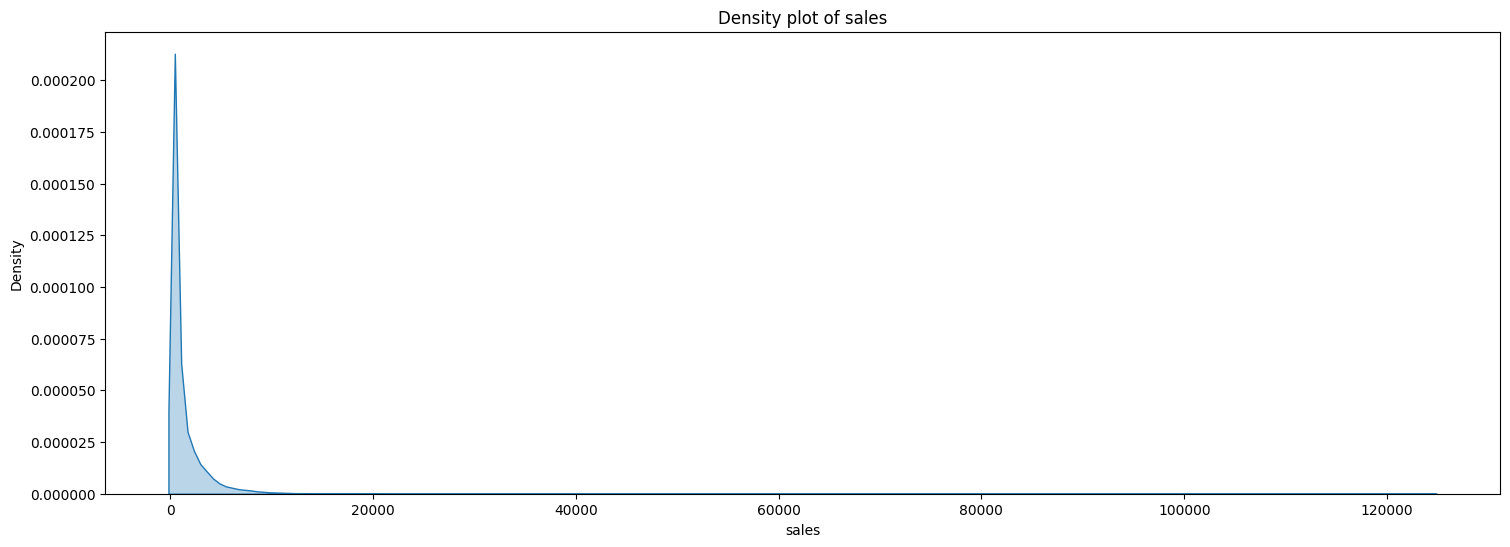

In [42]:
plt.figure(figsize=(18, 6))
sns.kdeplot(df['sales'], fill=True, alpha=0.3)
plt.title('Density plot of sales')
plt.show()

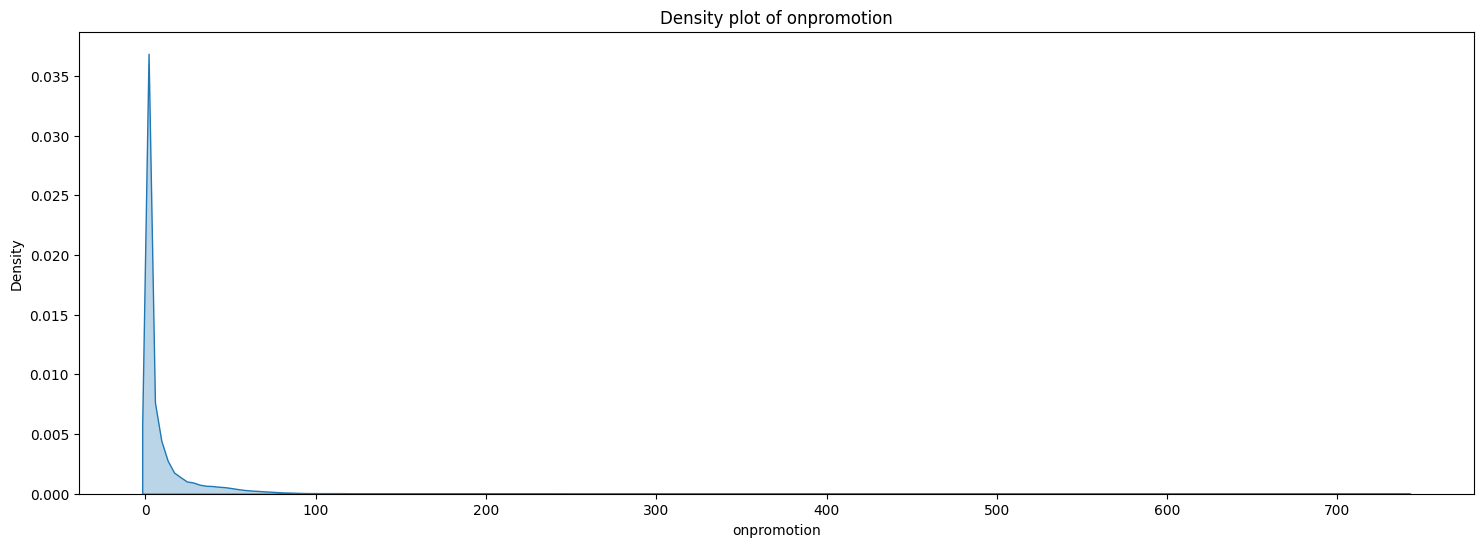

In [43]:


plt.figure(figsize=(18, 6))
sns.kdeplot(df['onpromotion'], fill=True, alpha=0.3)
plt.title('Density plot of onpromotion')
plt.show()


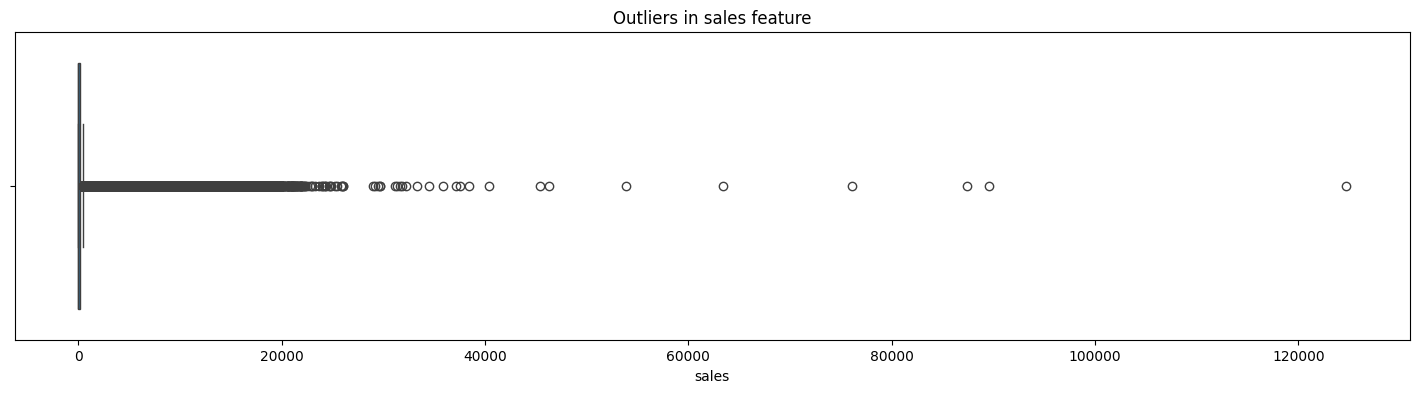

In [44]:
plt.figure(figsize =(18,4))
sns.boxplot(df['sales'], orient ='h')
plt.title('Outliers in sales feature')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

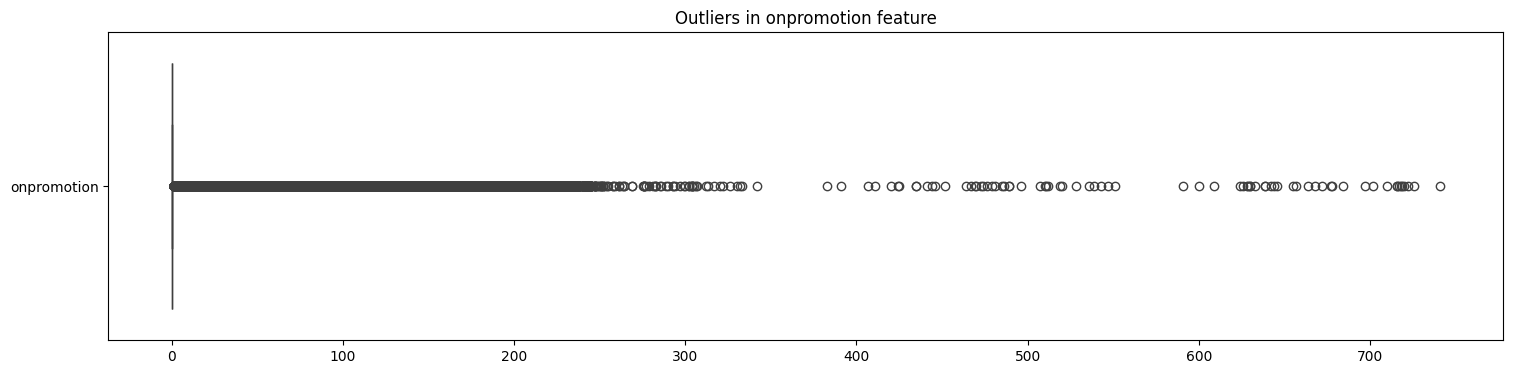

In [45]:
plt.figure(figsize = (18, 4))
sns.boxplot(df.drop(['sales','store_nbr'],axis = 1),orient = 'h')
plt.title('Outliers in onpromotion feature')
plt.show

### Biveriate Analysis

In [46]:
# Create new features to check for better correlation
def create_new_features(df):
    df['month_name'] = df.index.month_name()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day'] = df.index.dayofweek
    
    return df
df = create_new_features(df)
df

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1
...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,1
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,1
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,1


In [47]:
# Create a correlation heatmap
correlation = df.drop(['family','month_name','day','year','month'], axis = 1).corr()
correlation

,store_nbr,sales,onpromotion
store_nbr,1.00,0.04,0.01
sales,0.04,1.00,0.43
onpromotion,0.01,0.43,1.00


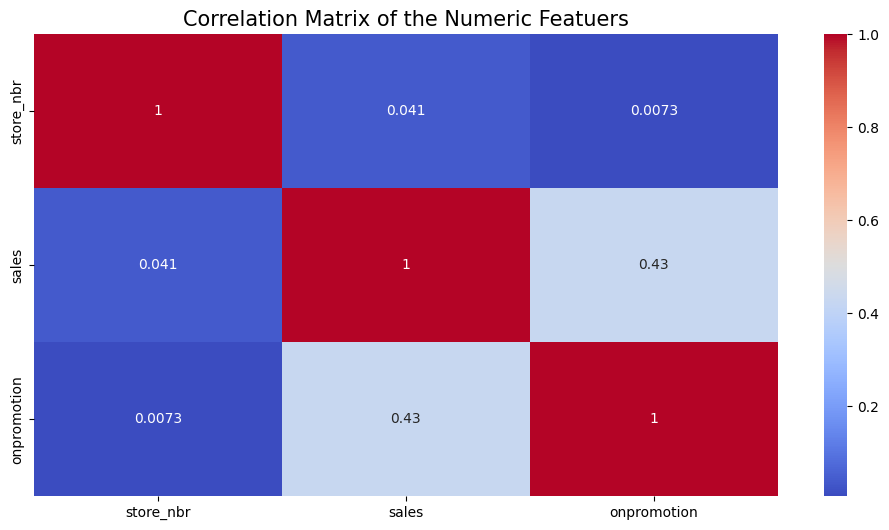

In [48]:
plt.figure(figsize = (12, 6))
sns.heatmap(correlation, annot=True, cmap = 'coolwarm')
plt.title('Correlation Matrix of the Numeric Featuers', fontsize =15)
plt.show()

Positive Correlation Between Sales and Promotions: The correlation matrix indicates a positive correlation between sales and the number of promotions. The correlation coefficient is 0.8, suggesting a strong positive association. With a coefficient of 1 indicating perfect positive correlation, 0.8 signifies a substantial tendency for sales to increase along with the number of promotions.
Important Note: Correlation does not imply causation. While a positive correlation exists, it doesn't necessarily mean that running more promotions directly causes increased sales. Other factors might influence both sales and promotions, leading to this observed correlation.

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


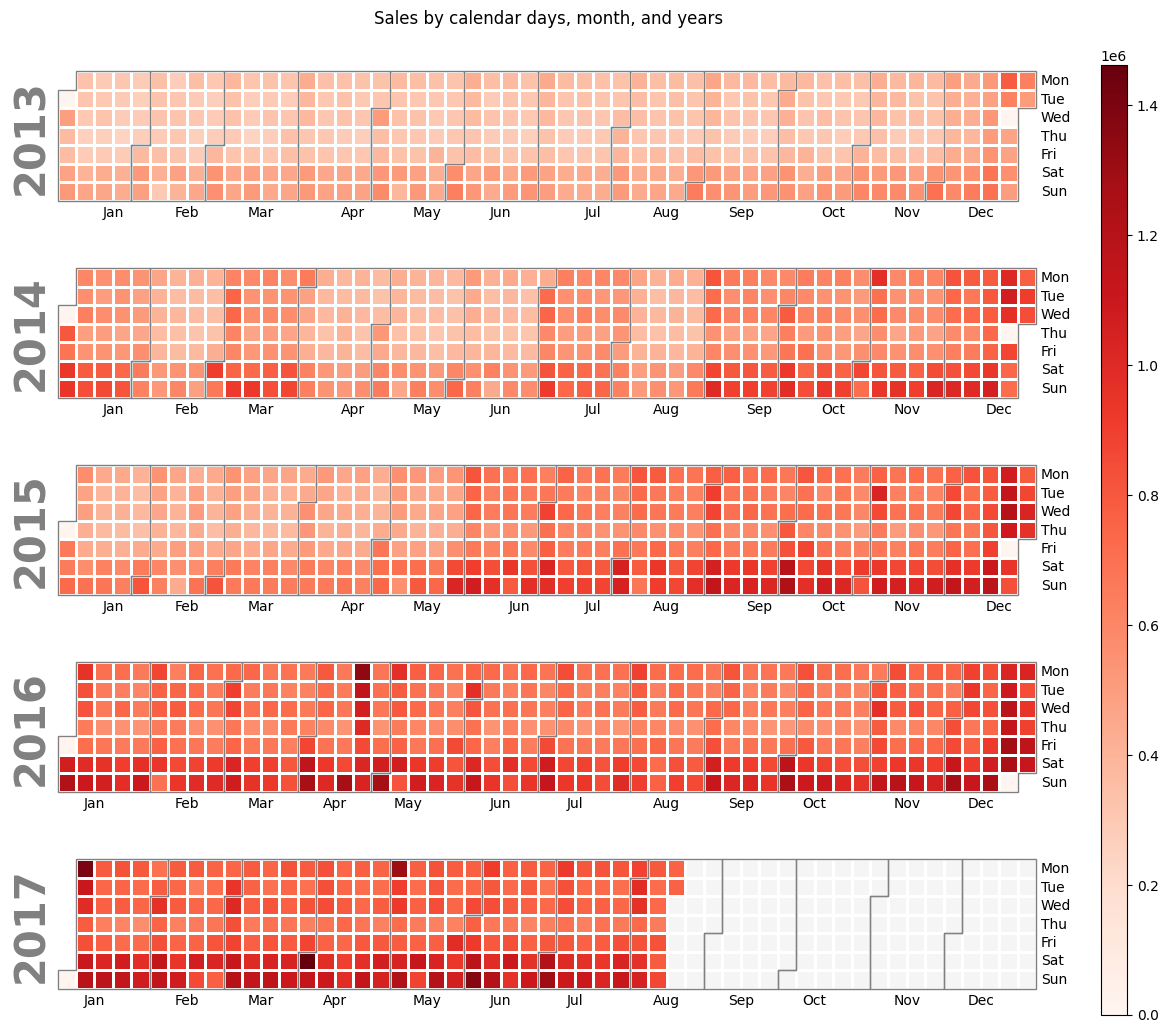

In [49]:


# Assuming df is your DataFrame containing the sales data
calplot.calplot(df['sales'], how='sum', cmap='Reds', figsize=(13, 10), suptitle='Sales by calendar days, month, and years')
plt.show()



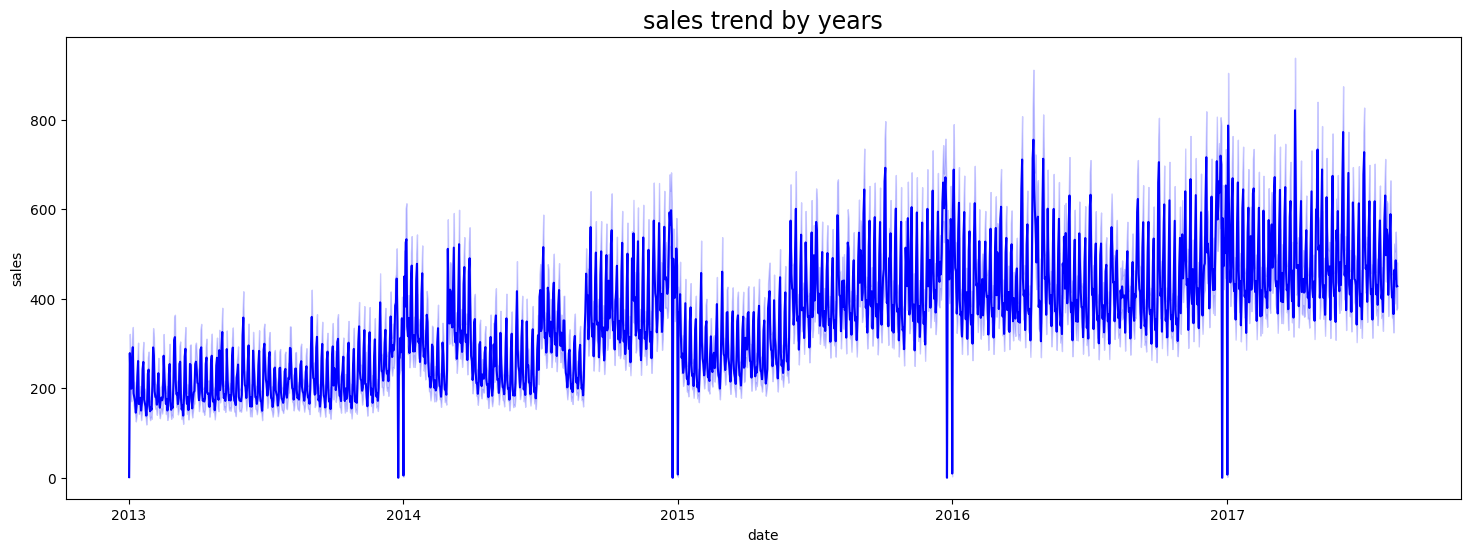

In [50]:
plt.figure(figsize=(18, 6))
sns.lineplot(data =df, x = df.index,y ='sales',color = 'blue')
plt.title('sales trend by years', fontsize = 17)
plt.show()

### Decomposition

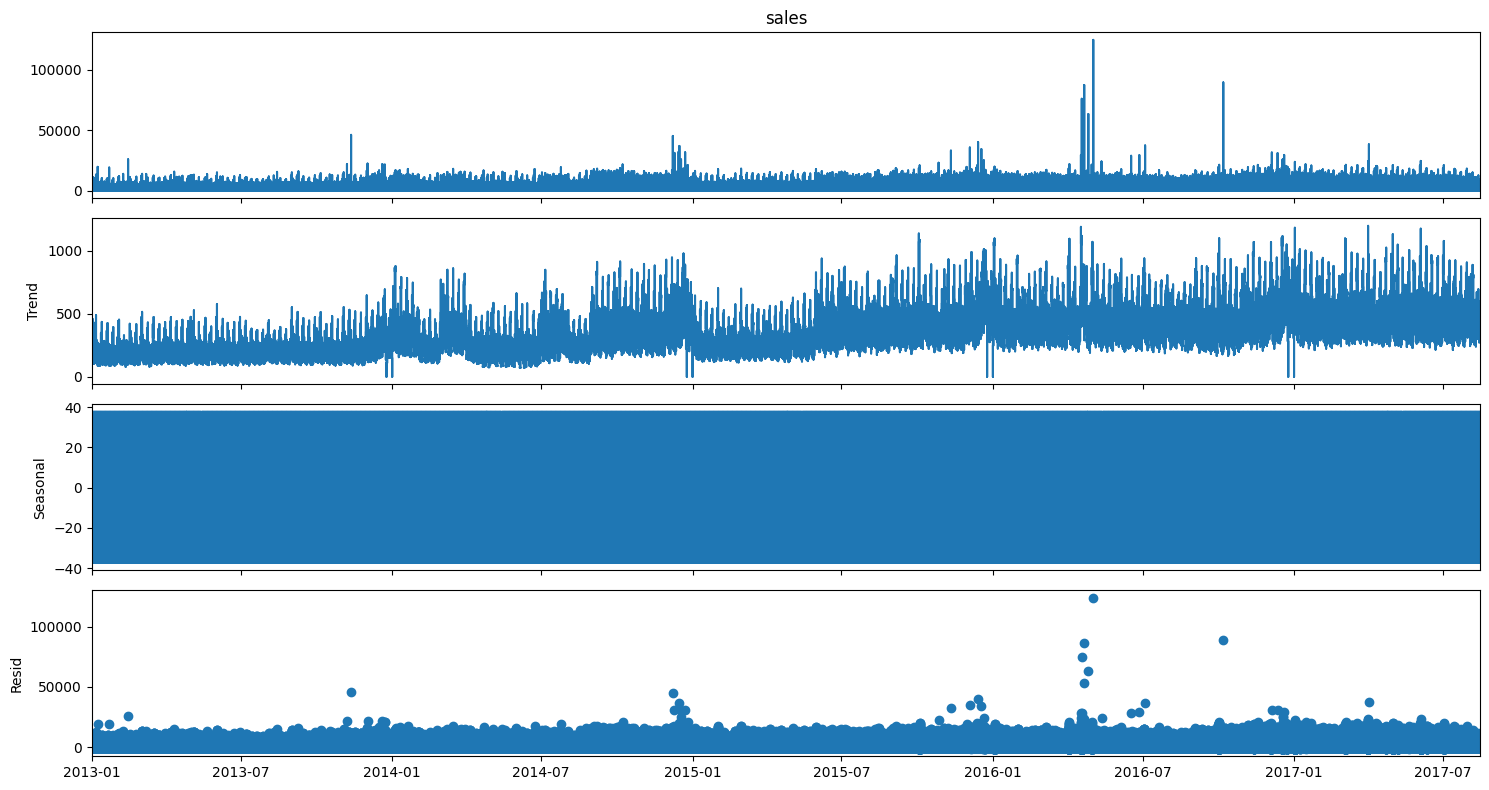

In [51]:


# Assuming df is your DataFrame containing the sales data
results = seasonal_decompose(df['sales'], model='additive', period=365)
plt.rcParams.update({'figure.figsize': (15, 8)})
results.plot()
plt.show()



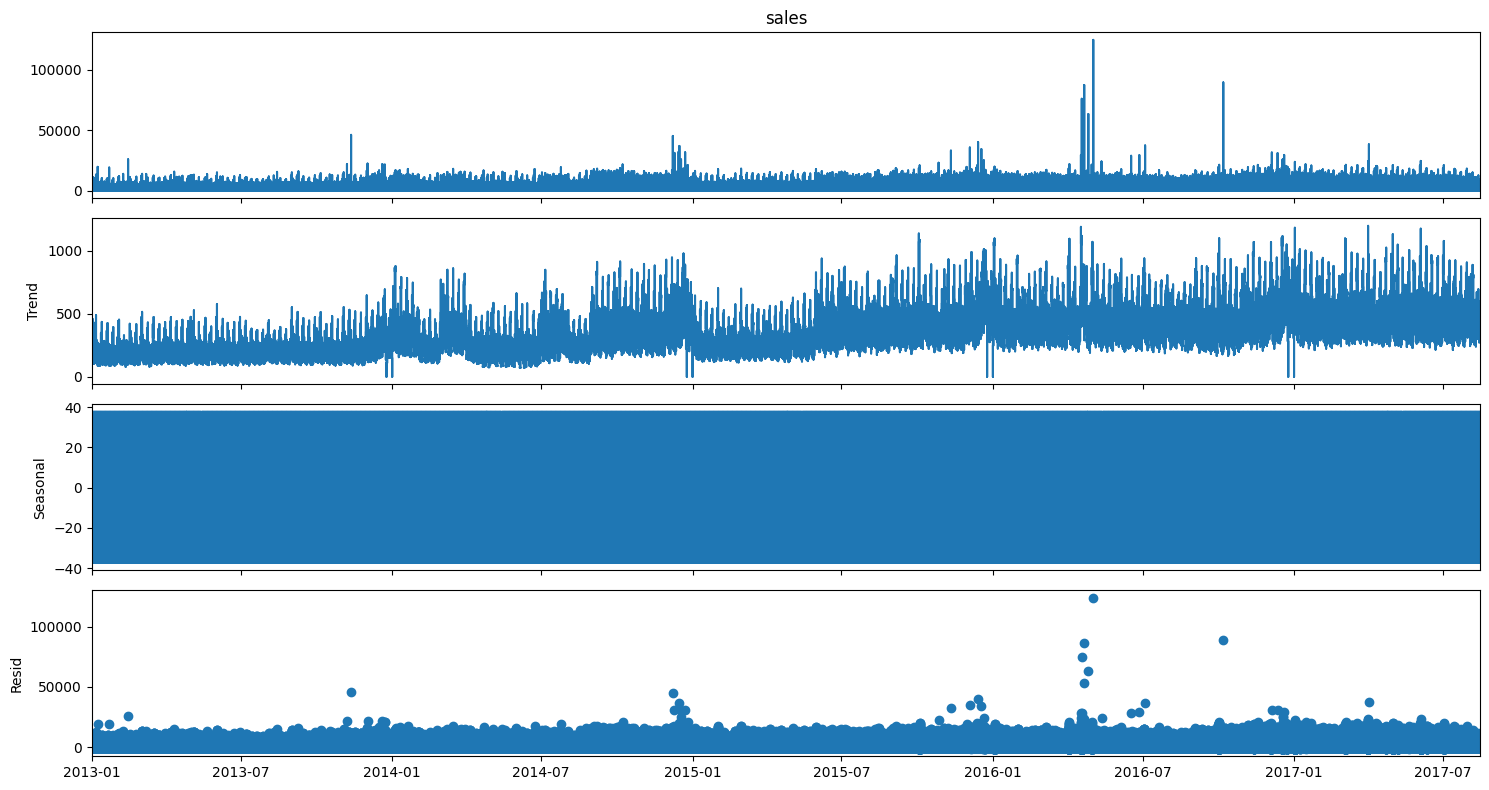

In [52]:


# Assuming df is your DataFrame containing the sales data
results = seasonal_decompose(df['sales'], model='additive', period=365)
plt.rcParams.update({'figure.figsize': (15, 8)})
results.plot()
plt.show()


In [53]:
# Extract components and create a new dataframe
decomposition_df = pd.DataFrame({
    'Trend': results.trend,
    'Seasonality': results.seasonal,
    'Residual': results.resid,
    'Observed': results.observed,
})
decomposition_df



,Trend,Seasonality,Residual,Observed
date,,,,
2013-01-01,NaN,9.23,NaN,0.00
2013-01-01,NaN,-3.24,NaN,0.00
2013-01-01,NaN,-5.17,NaN,0.00
2013-01-01,NaN,-10.93,NaN,0.00
2013-01-01,NaN,-5.84,NaN,0.00
...,...,...,...,...
2017-08-15,NaN,13.01,NaN,172.52
2017-08-15,NaN,13.57,NaN,3.00
2017-08-15,NaN,-7.78,NaN,3.00


In [54]:
decomposition_df.tail(1000)

,Trend,Seasonality,Residual,Observed
date,,,,
2017-08-15,549.31,-18.79,-312.64,217.89
2017-08-15,549.15,-3.12,830.97,1377.00
2017-08-15,551.85,-9.34,814.49,1357.00
2017-08-15,552.01,8.28,-544.29,16.00
2017-08-15,552.34,-13.90,166.36,704.80
...,...,...,...,...
2017-08-15,NaN,13.01,NaN,172.52
2017-08-15,NaN,13.57,NaN,3.00
2017-08-15,NaN,-7.78,NaN,3.00


In [55]:
df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1


### Stationary Testing

- Due to the size of the dataset, down size the data by converting my daily data to weekly data
- Aggregate the means of the 7 days of the week

In [56]:
# resample and calculate the mean only on the sales column
df_downsampled = df[['sales']].resample('W').mean()

#Check if there are NaN values and handle them appropriately
df_downsampled.fillna(0, inplace=True)

df_downsampled

,sales
date,
2013-01-06,206.84
2013-01-13,190.29
2013-01-20,189.84
2013-01-27,182.15
2013-02-03,198.56
...,...
2017-07-23,460.50
2017-07-30,474.73
2017-08-06,513.88


In [57]:
# Use the ADF to calculate the stationarity in sales
result = adfuller(df_downsampled['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -1.481750917756024
p-value: 0.5425188110982654
Data is not stationary


In [58]:
result

(-1.481750917756024,
 0.5425188110982654,
 13,
 228,
 {'1%': -3.4593607492757554,
  '5%': -2.8743015807562924,
  '10%': -2.5735714042782396},
 2278.6898598939215)

### Visualizing stationarity using Rolling statistics

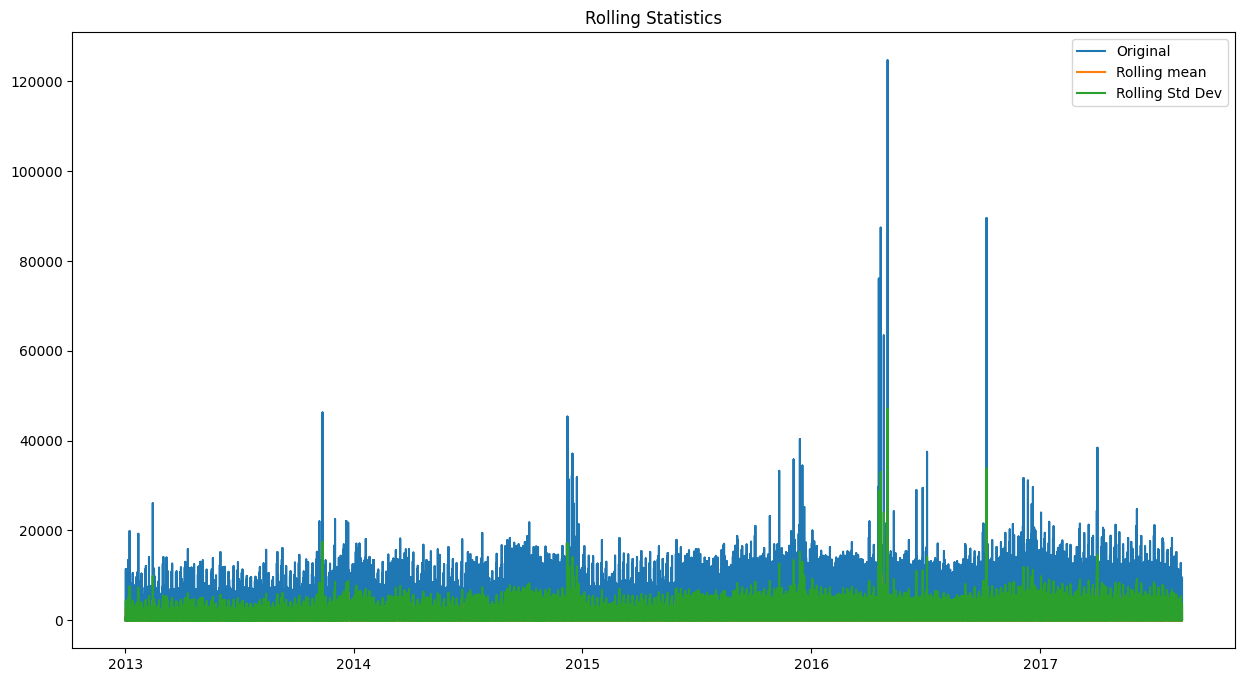

In [59]:
# Rolling mean and std dev
rolling_mean = df['sales'].rolling(window=7).mean()
rolling_std = df['sales'].rolling(window=7).std()

plt.plot(df['sales'], label ='Original')
plt.plot(rolling_mean, label = 'Rolling mean')
plt.plot(rolling_std, label = 'Rolling Std Dev')
plt.legend(loc ='best')
plt.title('Rolling Statistics')
plt.show()

### Key Insights - Visualization

1. The sales and onpromotion columns are heavily skewed with alot of outliers
2. The data is not Stationary which means it does not maintain a constant mean, variance and co-variance over time

### Answering Analytical Questions 
#### Research questions

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Did the earthquake impact sales?
4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?
7. Which product family and stores did the promotions affect.
8. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
9. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.
10. Compare the sales for each month across the years and determine which month of which year had the highest sales.

1. Is the train dataset complete(has all required dates)?

- This question was answered during the checking for data completeness earlier in the notebook.
- There were 4 missing days from the range given in the train dataset



2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

i. Group sales by date

In [60]:
sales_df = df.groupby('date')['sales'].sum().reset_index()
sales_df

,date,sales
0,2013-01-01,2511.62
1,2013-01-02,496092.42
2,2013-01-03,361461.23
3,2013-01-04,354459.68
4,2013-01-05,477350.12
...,...,...
1683,2017-08-11,826373.72
1684,2017-08-12,792630.54
1685,2017-08-13,865639.68
1686,2017-08-14,760922.41


In [61]:
df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1


In [62]:
original_df = df.copy()


In [63]:
original_df['sales_date'] = original_df.index

In [64]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [65]:
# Filter out days when the store was closed (zero sales)
filt_df = df[df['sales'] > 0]
filt_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,25,GROCERY II,15.00,0.00,January,1,2013,1
2013-01-01,25,GROCERY I,700.00,0.00,January,1,2013,1
2013-01-01,25,FROZEN FOODS,29.65,0.00,January,1,2013,1
2013-01-01,25,DELI,71.09,0.00,January,1,2013,1
2013-01-01,25,DAIRY,143.00,0.00,January,1,2013,1


In [66]:
closed_days = df[df['sales'] > 0]
closed_days.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,25,GROCERY II,15.00,0.00,January,1,2013,1
2013-01-01,25,GROCERY I,700.00,0.00,January,1,2013,1
2013-01-01,25,FROZEN FOODS,29.65,0.00,January,1,2013,1
2013-01-01,25,DELI,71.09,0.00,January,1,2013,1
2013-01-01,25,DAIRY,143.00,0.00,January,1,2013,1


ii. Aggregate sales by date and year

In [67]:


# Reset index to convert 'date' from index to a column
filt_df.reset_index(inplace=True)

# Convert 'date' column to datetime format
filt_df['date'] = pd.to_datetime(filt_df['date'])

# Extract year from the 'date' column
filt_df['year'] = filt_df['date'].dt.year

# Aggregate sales by date and year
sales_by_date_year = filt_df.groupby(['year', 'date'])['sales'].sum().reset_index()

# Find the dates with the lowest and highest sales for each year
lowest_sales_dates = sales_by_date_year.loc[sales_by_date_year.groupby('year')['sales'].idxmin()]
highest_sales_dates = sales_by_date_year.loc[sales_by_date_year.groupby('year')['sales'].idxmax()]

# Format sales numbers as comma-separated with two decimal places
lowest_sales_dates['sales'] = lowest_sales_dates['sales'].apply(lambda x: '{:,.2f}'.format(x))
highest_sales_dates['sales'] = highest_sales_dates['sales'].apply(lambda x: '{:,.2f}'.format(x))

print("Dates with lowest sales for each year:")
print(lowest_sales_dates)

print("\nDates with highest sales for each year:")
print(highest_sales_dates)



Dates with lowest sales for each year:
      year       date      sales
0     2013 2013-01-01   2,511.62
364   2014 2014-01-01   8,602.07
728   2015 2015-01-01  12,773.62
1092  2016 2016-01-01  16,433.39
1457  2017 2017-01-01  12,082.50

Dates with highest sales for each year:
      year       date         sales
356   2013 2013-12-23    792,865.28
720   2014 2014-12-23  1,064,977.97
1004  2015 2015-10-04  1,234,130.94
1200  2016 2016-04-18  1,345,920.60
1547  2017 2017-04-01  1,463,083.96


3. Did the earthquake impact sales?

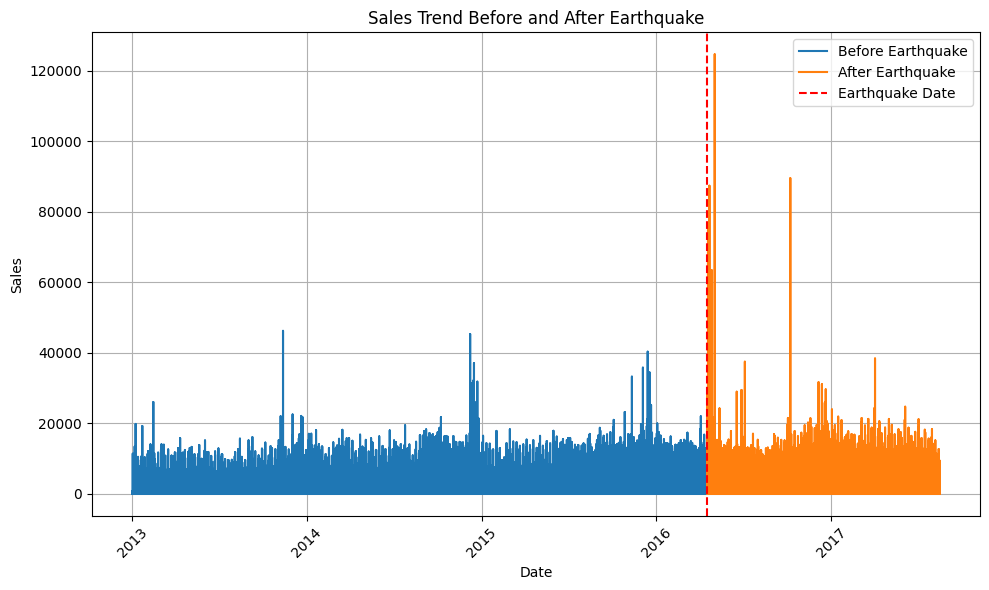

Sales did not significantly change after the earthquake.


In [68]:


# Check for sales trend before and after the earthquake
earthquake_date = '2016-04-16'
before_earthquake_data = df[df.index < earthquake_date]
after_earthquake_data = df[df.index > earthquake_date]

# Calculate mean sales before and after the earthquake
before_earthquake_sales = before_earthquake_data['sales'].mean()
after_earthquake_sales = after_earthquake_data['sales'].mean()

# Create a line plot to visualize sales trend before and after the earthquake
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_data.index, before_earthquake_data['sales'], label='Before Earthquake')
plt.plot(after_earthquake_data.index, after_earthquake_data['sales'], label='After Earthquake')
plt.axvline(x=pd.to_datetime(earthquake_date), color='red', linestyle='--', label='Earthquake Date')
plt.title('Sales Trend Before and After Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the comparison result
if before_earthquake_sales > after_earthquake_sales:
    print("Sales decreased after the earthquake.")
else:
    print("Sales did not significantly change after the earthquake.")


4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

- Merge df to store_df get access to cluster, city, state and type
- visualize each category

In [69]:
merged_df = pd.merge(df, store,on ='store_nbr', how = 'inner')
merged_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster
0,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Quito,Pichincha,D,13
1,42,CELEBRATION,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
2,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
3,42,BOOKS,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
4,42,BEVERAGES,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2


In [70]:
merged_df['state'].unique()

array(['Pichincha', 'Azuay', 'El Oro', 'Esmeraldas', 'Guayas', 'Loja',
       'Manabi', 'Tungurahua', 'Santo Domingo de los Tsachilas',
       'Los Rios', 'Bolivar', 'Imbabura', 'Cotopaxi', 'Chimborazo',
       'Pastaza', 'Santa Elena'], dtype=object)

In [71]:
merged_df['state'].nunique()

16

### Sales by state

In [72]:
sales_by_state =merged_df.groupby(['state'])['sales'].sum().reset_index().sort_values(by ='sales',ascending = False)
sales_by_state

,state,sales
12,Pichincha,585067395.31
6,Guayas,165154392.38
0,Azuay,49168596.03
15,Tungurahua,40304401.30
14,Santo Domingo de los Tsachilas,35834323.04
4,El Oro,33386796.54
9,Los Rios,31925373.99
10,Manabi,24969820.13
3,Cotopaxi,21182263.78
8,Loja,18859999.26


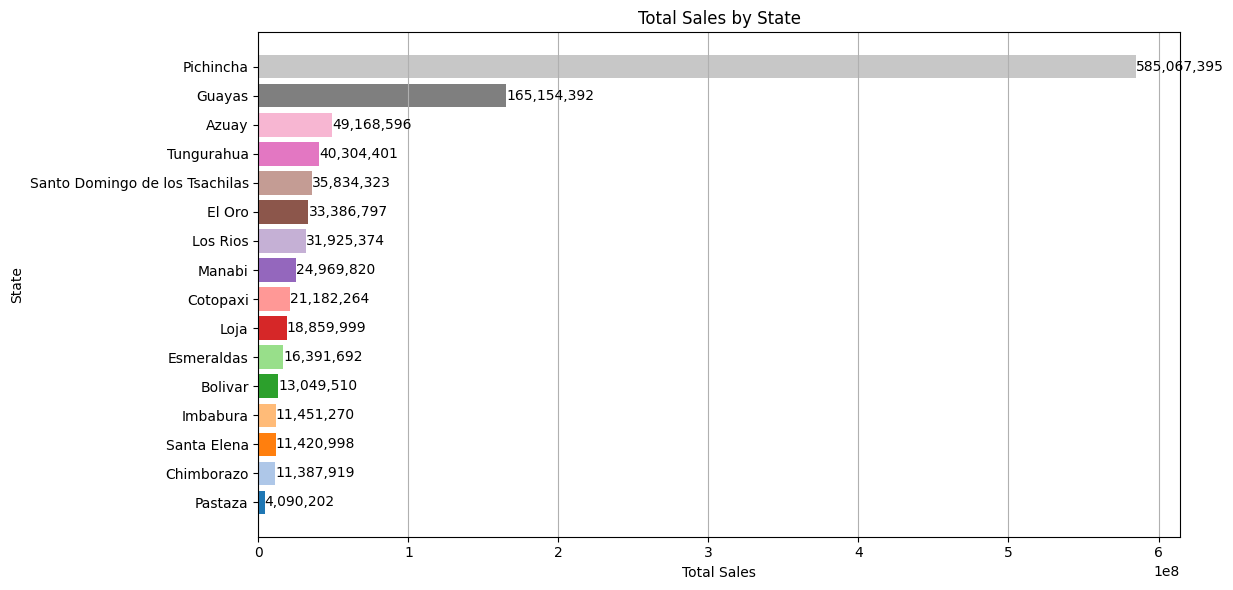

In [73]:


# Sort the data by sales in descending order
sales_by_state_sorted = sales_by_state.sort_values(by='sales', ascending=True)

# Generate a range of colors using a colormap
colors = plt.cm.tab20.colors[:len(sales_by_state_sorted)]

# Visualize state by sales
plt.figure(figsize=(12, 6))
bars = plt.barh(sales_by_state_sorted['state'], sales_by_state_sorted['sales'], color=colors)
plt.title('Total Sales by State')
plt.xlabel('Total Sales')
plt.ylabel('State')
plt.grid(axis='x')  # Change grid to align with x-axis in horizontal bars
plt.tight_layout()

# Add value annotations with commas for thousands
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:,.0f}', 
             ha='left', va='center')

plt.show()


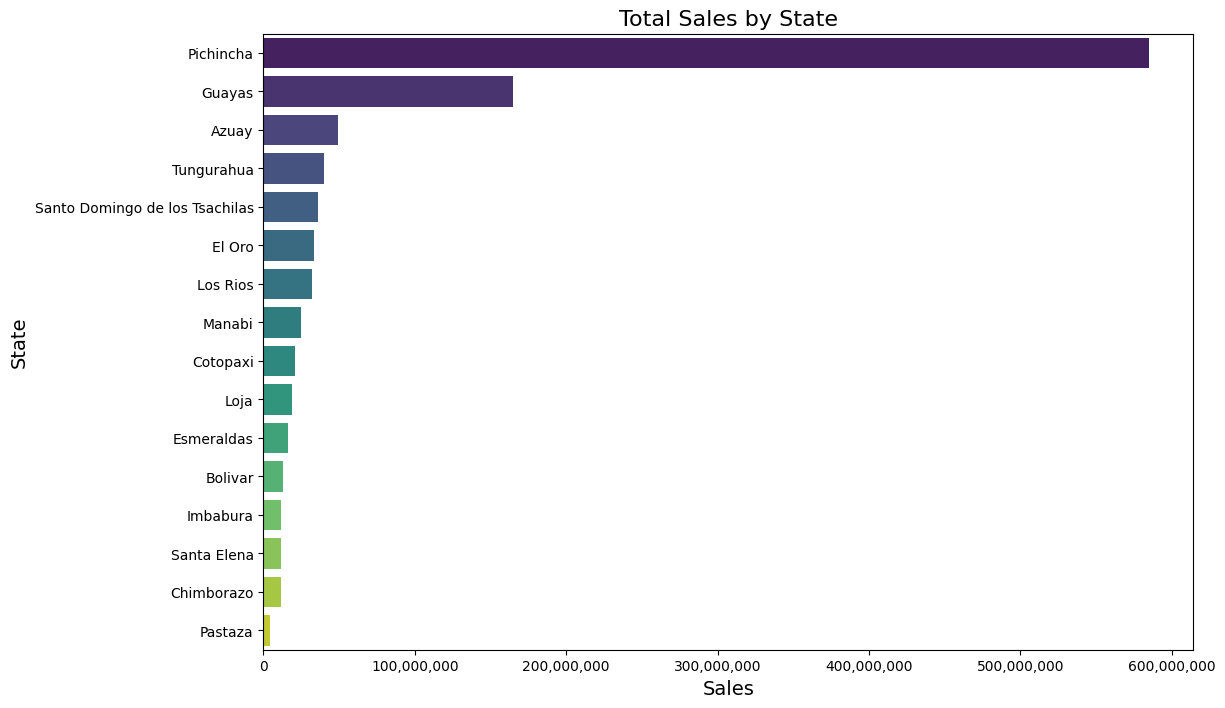

In [74]:
# Your data
data = sales_by_state

# Create DataFrame
sales_by_state = pd.DataFrame(data)

# Create bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=sales_by_state, x='sales', y='state', palette='viridis')

# Add labels
plt.xlabel('Sales', fontsize=14)
plt.ylabel('State', fontsize=14)  # Corrected ylabel from 'state' to 'State'
plt.title('Total Sales by State', fontsize=16)

# Format x-axis to add comma separators
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()


### Sales by City 

In [75]:
merged_df['city'].unique()

array(['Quito', 'Cuenca', 'Machala', 'Esmeraldas', 'Libertad', 'Playas',
       'Guayaquil', 'Loja', 'El Carmen', 'Manta', 'Ambato',
       'Santo Domingo', 'Quevedo', 'Guaranda', 'Ibarra', 'Cayambe',
       'Latacunga', 'Riobamba', 'Babahoyo', 'Puyo', 'Daule', 'Salinas'],
      dtype=object)

In [76]:
merged_df['city'].nunique()

22

In [77]:
sales_by_city=merged_df.groupby(['city'])['sales'].sum().reset_index().sort_values(by ='sales',ascending = False)
sales_by_city

,city,sales
18,Quito,556741836.83
8,Guayaquil,122967260.48
3,Cuenca,49168596.03
0,Ambato,40304401.30
21,Santo Domingo,35834323.04
13,Machala,33386796.54
2,Cayambe,28325558.48
10,Latacunga,21182263.78
4,Daule,19188021.38
12,Loja,18859999.26


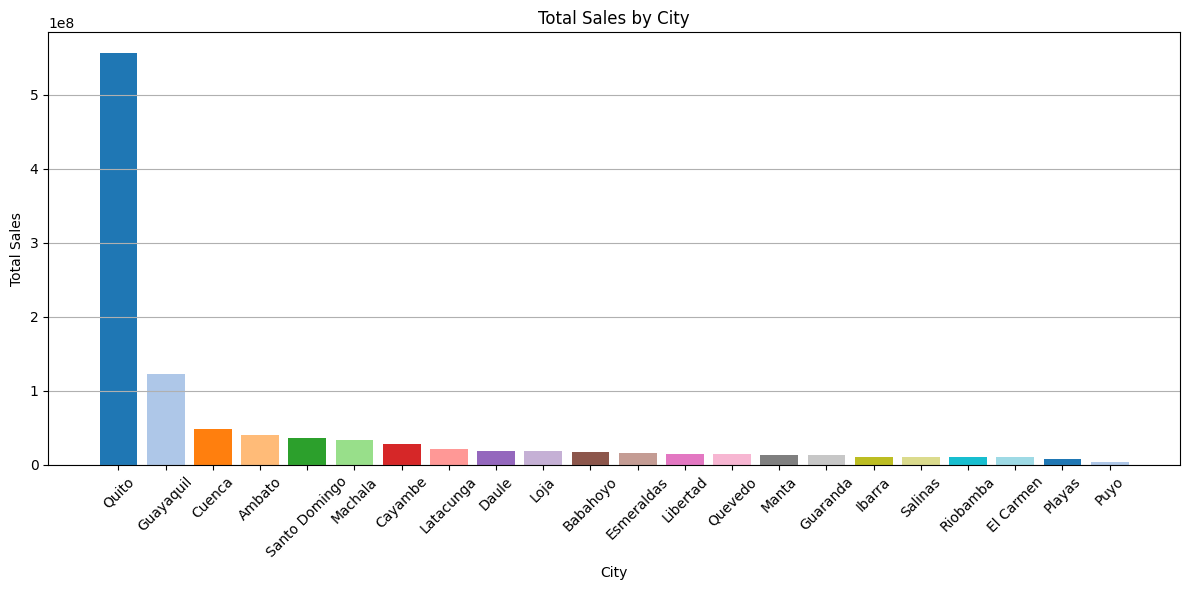

In [78]:


# Create a list of unique colors for each bar
colors = plt.cm.tab20.colors[:len(sales_by_city)]

# Visualize sales by city
plt.figure(figsize=(12, 6))
plt.bar(sales_by_city['city'], sales_by_city['sales'], color=colors)
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Sales by Cluster 


In [79]:
sales_by_cluster=merged_df.groupby(['cluster'])['sales'].sum().reset_index().sort_values(by ='sales',ascending = False)
sales_by_cluster

,cluster,sales
13,14,157430523.08
5,6,114254386.74
7,8,107928246.70
10,11,100614275.93
9,10,85324430.43
2,3,75628703.46
12,13,72102248.79
4,5,62087553.25
14,15,55296949.37
0,1,54376751.96


In [80]:
sales_by_type = merged_df.groupby(['type'])['sales'].sum().reset_index().sort_values(by ='sales',ascending = False)
sales_by_type

,type,sales
0,A,353043841.80
3,D,351083296.86
2,C,164434742.56
1,B,145260635.13
4,E,59822435.84


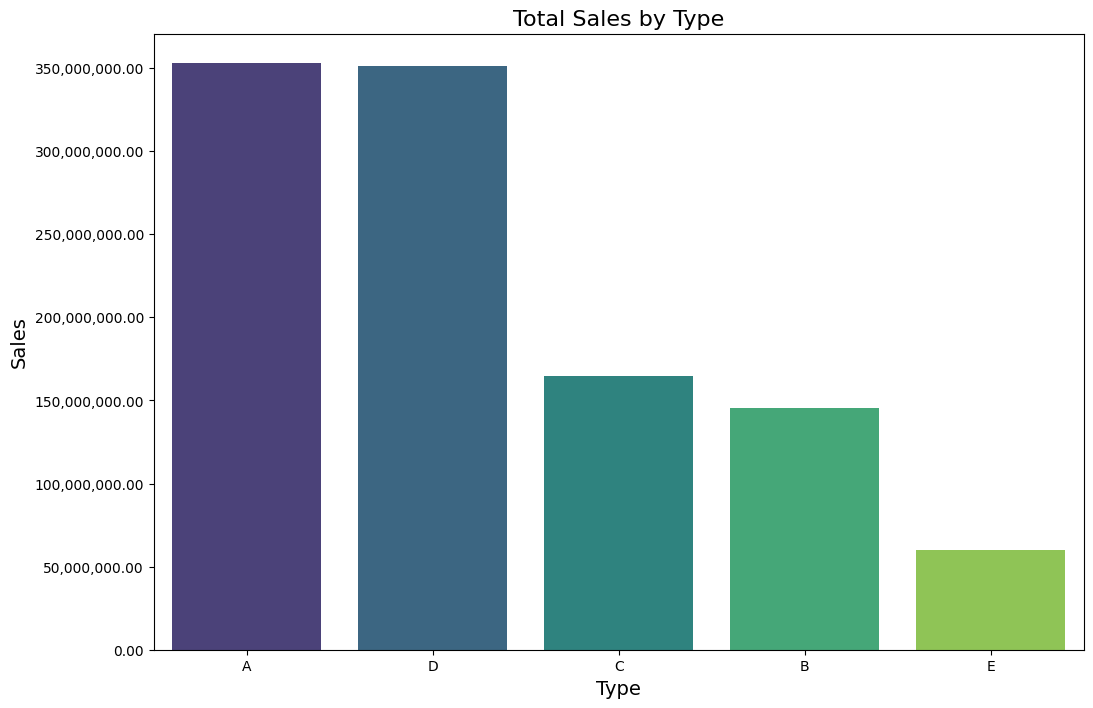

In [81]:
sales_by_type = pd.DataFrame(sales_by_type)

# Create bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=sales_by_type, x='type', y='sales', palette='viridis')

# Add labels
plt.xlabel('Type', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.title('Total Sales by Type', fontsize=16)

# Format y-axis to add comma separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

plt.show()



5. Are sales affected by promotions, oil prices and holidays?

### Promotion analysis

In [82]:
df = merged_df

In [83]:
df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster
0,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Quito,Pichincha,D,13
1,42,CELEBRATION,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
2,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
3,42,BOOKS,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
4,42,BEVERAGES,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2


In [84]:
no_promotion_df = df[df['onpromotion'] == 0]

# Format with commas using an f-string
no_promotion_data_points = f'{no_promotion_df.shape[0]:,}'
print(f'Number of datapoints with no promotion is {no_promotion_data_points}')

Number of datapoints with no promotion is 2,396,687


In [85]:
promotion_df = df[df['onpromotion'] > 0]

# Format with commas using an f-string
promotion_data_points = f'{promotion_df.shape[0]:,}'
print(f'Number of datapoints with promotion is {promotion_data_points}')

Number of datapoints with promotion is 611,329


In [86]:
no_promotion_df = df[df['onpromotion'] == 0]
no_promotion_df = no_promotion_df.groupby('family')['sales'].sum().reset_index().sort_values('sales', ascending=False)
# Add thousands seperatorto sales column
no_promotion_df['sales_format'] = no_promotion_df['sales'].apply(lambda x: f'{x:,.0f}')
no_promotion_df = no_promotion_df.nlargest(10,'sales')
no_promotion_df



,family,sales,sales_format
12,GROCERY I,92538393.70,"92,538,394"
3,BEVERAGES,50697146.00,"50,697,146"
30,PRODUCE,47646514.14,"47,646,514"
7,CLEANING,35634773.00,"35,634,773"
28,POULTRY,22319444.02,"22,319,444"
8,DAIRY,21567990.00,"21,567,990"
24,MEATS,21054436.99,"21,054,437"
5,BREAD/BAKERY,19749869.49,"19,749,869"
25,PERSONAL CARE,11641426.00,"11,641,426"
9,DELI,11411278.33,"11,411,278"


In [87]:
promotion_df = df[df['onpromotion'] > 0]
promotion_df = promotion_df.groupby('family')['sales'].sum().reset_index().sort_values('sales', ascending=False)
# Add thousands seperatorto sales column
promotion_df['sales_format'] = promotion_df['sales'].apply(lambda x: f'{x:,.0f}')
promotion_df = promotion_df.nlargest(10,'sales')
promotion_df

,family,sales,sales_format
11,GROCERY I,250924341.19,"250,924,341"
3,BEVERAGES,166257340.00,"166,257,340"
29,PRODUCE,75058170.54,"75,058,171"
6,CLEANING,61886516.00,"61,886,516"
7,DAIRY,42919719.00,"42,919,719"
4,BREAD/BAKERY,22384076.09,"22,384,076"
24,PERSONAL CARE,12950625.00,"12,950,625"
8,DELI,12699044.14,"12,699,044"
17,HOME CARE,10068717.00,"10,068,717"
23,MEATS,10032031.41,"10,032,031"


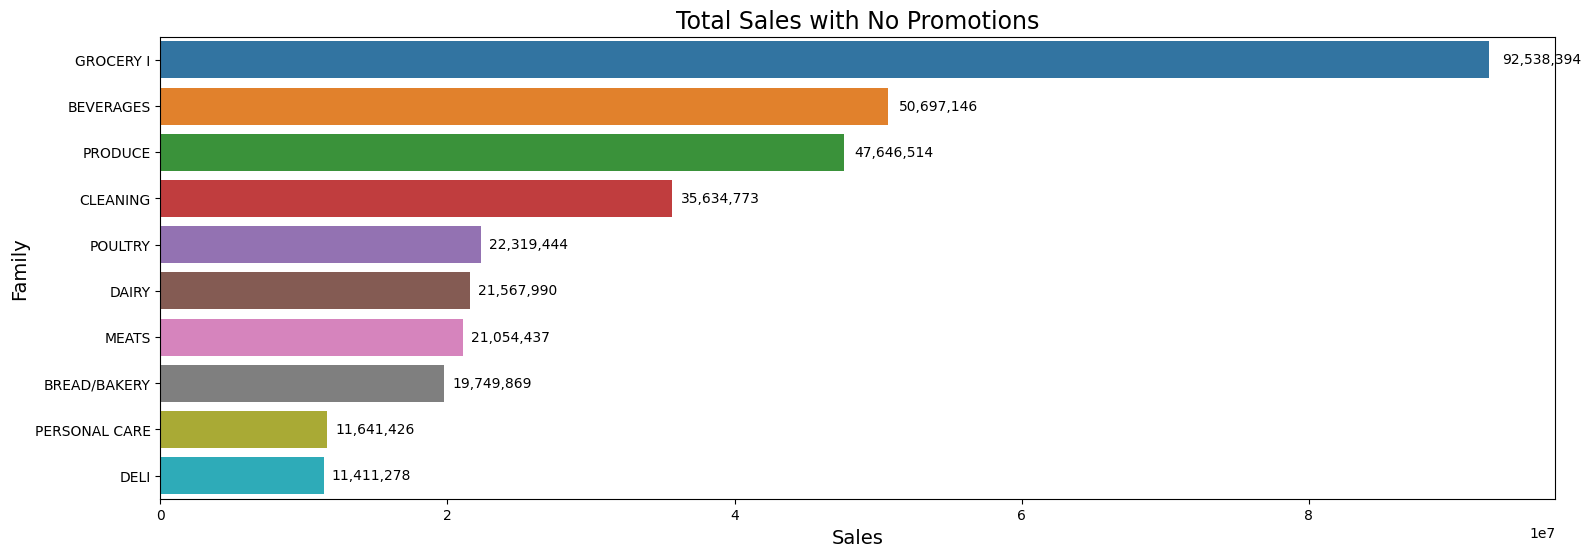

In [88]:
plt.figure(figsize=(18, 6))
ax = sns.barplot(data=no_promotion_df, x='sales', y='family', palette='tab10', orient='h')

# Add bar labels with thousands separator and padding for visibility
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}', ((p.get_width() * 1.005), p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.title('Total Sales with No Promotions', fontsize=17)
plt.xlabel('Sales', fontsize=14)
plt.ylabel('Family', fontsize=14)
plt.show()


### Oil Prices Analysis

In [89]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [90]:
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [91]:
oil_df.set_index('date', inplace = True)
oil_df.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [92]:
oil_start_date = oil_df.index.min()
oil_end_date = oil_df.index.max()

print(f'Oil start date is {oil_start_date}')
print(f'Oil end date is {oil_end_date}')

Oil start date is 2013-01-01 00:00:00
Oil end date is 2017-08-31 00:00:00


In [93]:
date_range_start_date = date_range.min()
date_range_end_date = date_range.max()

print(f'Train start date is {date_range_start_date}')
print(f'Train end date is {date_range_end_date}')

Train start date is 2013-01-01 00:00:00
Train end date is 2017-08-15 00:00:00


In [94]:
date_range.size

1688

In [95]:
oil_df.index.size

1218

In [96]:
missing_oil_dates = date_range.difference(oil_df.index)
print(f'Total missing days: {missing_oil_dates.nunique()}')
missing_oil_dates

Total missing days: 482


DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-15', '2017-07-16', '2017-07-22', '2017-07-23',
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13'],
              dtype='datetime64[ns]', length=482, freq=None)

In [97]:
missing_days_df = pd.DataFrame(missing_oil_dates, columns = ['date'])
missing_days_df

,date
0,2013-01-05
1,2013-01-06
2,2013-01-12
3,2013-01-13
4,2013-01-19
...,...
477,2017-07-30
478,2017-08-05
479,2017-08-06
480,2017-08-12


In [98]:
# Find out what days there are no valuesfor the oil data
#missing_days_df['Day of the week'] = missing_days_df['date'].apply(lambda x: x.strft)

# Assuming missing_dates is a DataFrame with a column named 'date'
missing_days_df['Day of the Week'] = missing_days_df['date'].apply(lambda x: x.strftime('%A'))
missing_days_df.set_index('date', inplace = True)


In [99]:
missing_days_df.head()

,Day of the Week
date,
2013-01-05,Saturday
2013-01-06,Sunday
2013-01-12,Saturday
2013-01-13,Sunday
2013-01-19,Saturday


In [100]:
missing_days_df['Day of the Week'].unique()

array(['Saturday', 'Sunday'], dtype=object)

- Dates with oil missing were on Saturday and sunday
- This mean that prices are not recorded on friday
- i will use the foward fill to fill the last recorded price on Fridaysince all prices do not flactuate

In [101]:
#oil prices missing from the original prices
oil_df.isna().sum()

dcoilwtico    43
dtype: int64

In [102]:
#oil prices missing from the missing dates
missing_days_df.isna().sum()

Day of the Week    0
dtype: int64

In [103]:
missing_days_df.isna().sum()


Day of the Week    0
dtype: int64

In [104]:
#all missing oil prices
full_oil_data = pd.concat([oil_df,missing_days_df])
full_oil_data.isna().sum()

dcoilwtico          525
Day of the Week    1218
dtype: int64

In [105]:
full_oil_data.drop('Day of the Week',axis = 1, inplace = True)


In [106]:
full_oil_data

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,NaN
2017-08-05,NaN
2017-08-06,NaN


In [107]:
full_oil_data['dcoilwtico']=full_oil_data['dcoilwtico'].fillna(method = 'ffill')
full_oil_data.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [108]:
full_oil_data.isna().sum() #The first value need to be manually filled since we used a ffill

dcoilwtico    1
dtype: int64

In [109]:
full_oil_data.loc['2013-01-01']

dcoilwtico   NaN
Name: 2013-01-01 00:00:00, dtype: float64

In [110]:
full_oil_data.loc['2013-01-01'] = 93.14

In [111]:
full_oil_data.isna().sum()

dcoilwtico    0
dtype: int64

In [112]:
# filtering out excess days since oil_df had 15 more days than train _df
excess_oil_days = full_oil_data[full_oil_data.index > '2017-08-15']
excess_oil_days

,dcoilwtico
date,
2017-08-16,46.80
2017-08-17,47.07
2017-08-18,48.59
2017-08-21,47.39
2017-08-22,47.65
2017-08-23,48.45
2017-08-24,47.24
2017-08-25,47.65
2017-08-28,46.40


In [113]:
#drop excess days as the oil dates since the oildata ended about 2 weeks after the sales data ended
full_oil_data_df = full_oil_data.drop(excess_oil_days.index,axis = 0)
full_oil_data_df

,dcoilwtico
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,47.26
2017-08-05,47.26
2017-08-06,47.26


In [114]:
full_oil_data_df = full_oil_data_df.rename(columns = {'dcoilwtico': 'oil_price'})
full_oil_data_df

,oil_price
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,47.26
2017-08-05,47.26
2017-08-06,47.26


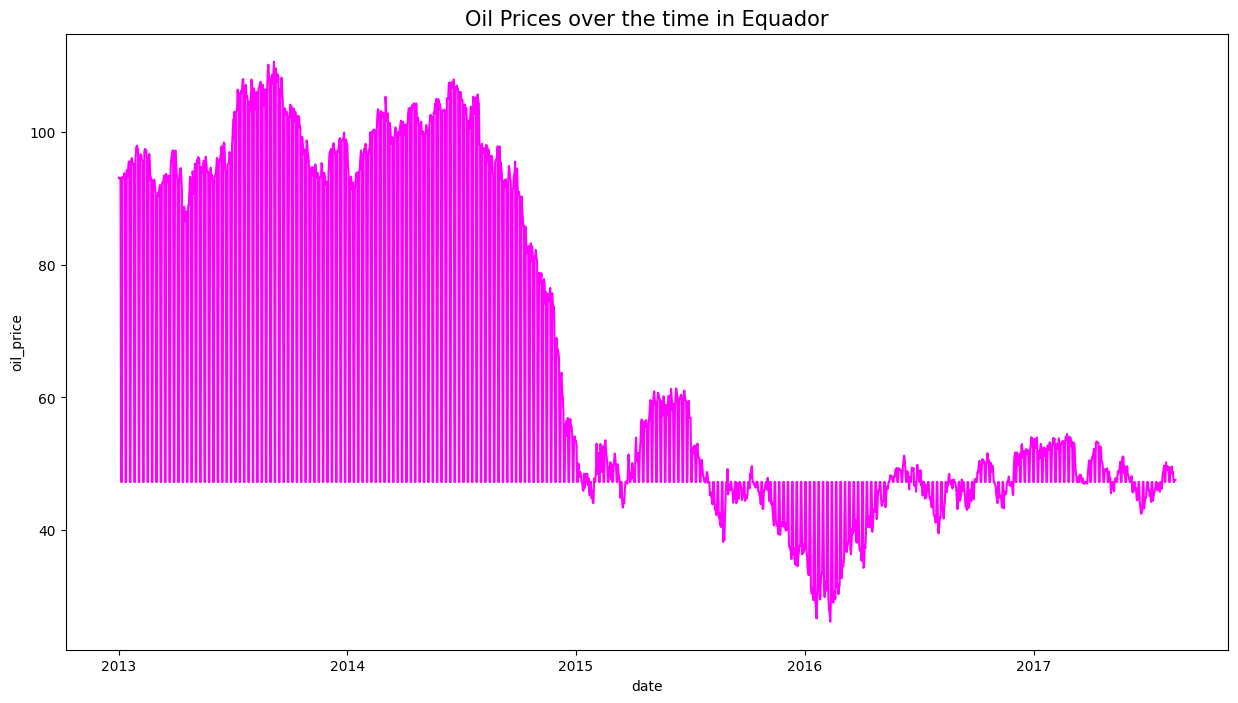

In [115]:
sns.lineplot(data = full_oil_data_df, x = full_oil_data_df.index, y = 'oil_price', color = 'magenta')
plt.title('Oil Prices over the time in Equador', fontsize = 15)
plt.show()

In [116]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [117]:
merged_with_oil_df = pd.merge(original_df, full_oil_data_df, on = 'date', how ='inner')
merged_with_oil_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date,oil_price
date,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01,93.14
...,...,...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,1,2017-08-15,47.57
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,1,2017-08-15,47.57
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,1,2017-08-15,47.57


In [118]:
sales_by_oil_data = merged_with_oil_df.groupby(['date', 'oil_price'])['sales'].sum().reset_index()
sales_by_oil_data

,date,oil_price,sales
0,2013-01-01,93.14,2511.62
1,2013-01-02,93.14,496092.42
2,2013-01-03,92.97,361461.23
3,2013-01-04,93.12,354459.68
4,2013-01-05,47.26,477350.12
...,...,...,...
1683,2017-08-11,48.81,826373.72
1684,2017-08-12,47.26,792630.54
1685,2017-08-13,47.26,865639.68
1686,2017-08-14,47.59,760922.41


In [119]:
#Select the 7 highest oil prices - this will be a week of data
high_oil_prices = sales_by_oil_data.nlargest(7, 'oil_price')
high_oil_prices['price_category'] = 'High'
high_oil_prices

,date,oil_price,sales,price_category
248,2013-09-06,110.62,335442.25,High
239,2013-08-28,110.17,319322.06,High
251,2013-09-09,109.62,377151.71,High
238,2013-08-27,109.11,319688.22,High
254,2013-09-12,108.72,282855.73,High
245,2013-09-03,108.67,397680.42,High
240,2013-08-29,108.51,294518.69,High


In [120]:
# select the 7 lowest oil prices - this will be a week of data
low_oil_prices = sales_by_oil_data.nsmallest(7,'oil_price')
low_oil_prices['price_category'] = 'Low'
low_oil_prices

,date,oil_price,sales,price_category
1136,2016-02-11,26.19,646376.37,Low
1114,2016-01-20,26.68,738744.01,Low
1135,2016-02-10,27.54,790988.71,Low
1134,2016-02-09,27.96,746939.64,Low
1113,2016-01-19,28.47,630929.75,Low
1141,2016-02-16,29.05,719111.89,Low
1137,2016-02-12,29.32,698152.07,Low


In [121]:
merged_df = pd.concat([high_oil_prices, low_oil_prices])
merged_df


,date,oil_price,sales,price_category
248,2013-09-06,110.62,335442.25,High
239,2013-08-28,110.17,319322.06,High
251,2013-09-09,109.62,377151.71,High
238,2013-08-27,109.11,319688.22,High
254,2013-09-12,108.72,282855.73,High
245,2013-09-03,108.67,397680.42,High
240,2013-08-29,108.51,294518.69,High
1136,2016-02-11,26.19,646376.37,Low
1114,2016-01-20,26.68,738744.01,Low
1135,2016-02-10,27.54,790988.71,Low


In [122]:

# Group by price category
grouped_df = merged_df.groupby('price_category')

# Calculate summary statistics for each group
oil_merged_df = grouped_df.agg({
    'oil_price': 'mean',
    'sales': 'mean'
})

oil_merged_df

,oil_price,sales
price_category,,
High,109.35,332379.87
Low,27.89,710177.49


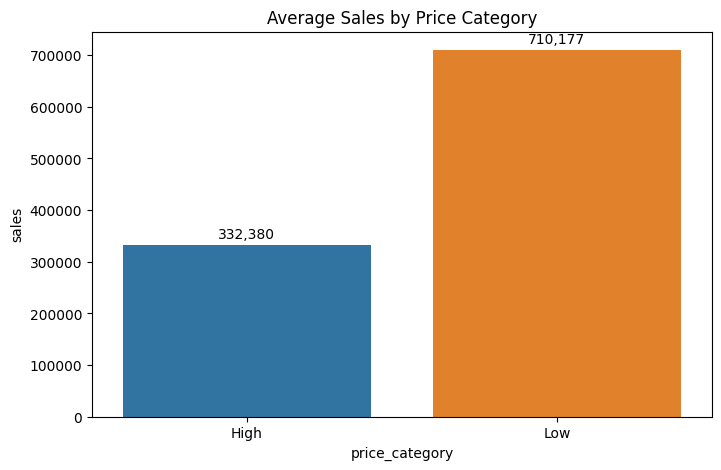

In [123]:
plt.figure(figsize =(8,5))
ax = sns.barplot(data = oil_merged_df, x = 'price_category',y = 'sales', hue ='price_category')

for container in ax.containers:
    ax.bar_label(container,fmt = '{:,.0f}', padding = 3)

plt.title('Average Sales by Price Category')
plt.show()

### Holidy Analysis

In [124]:
holiday_events_df.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [125]:
# Convert date to datetime
holiday_events_df['date'] = pd.to_datetime(holiday_events_df['date'])
holiday_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [126]:
holiday_events_df.set_index('date', inplace = True)
holiday_events_df.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [127]:
holiday_events_start_date = holiday_events_df.index.min()
holiday_events_end_date = holiday_events_df.index.max()

In [128]:
#Get the date between which holiday events were recorded
print(f'Holiday events start date is {holiday_events_start_date}')
print(f'Holiday events end date is {holiday_events_end_date}')

Holiday events start date is 2012-03-02 00:00:00
Holiday events end date is 2017-12-26 00:00:00


In [129]:
date_range.size

1688

In [130]:
holiday_events_df.index.size

350

In [131]:
date_range_start_date = date_range.min()
date_range_end_date = date_range.max()

print(f'Train start date is {date_range_start_date}')
print(f'Train end date is {date_range_end_date}')

Train start date is 2013-01-01 00:00:00
Train end date is 2017-08-15 00:00:00


In [132]:
missing_holiday_dates = date_range.difference(holiday_events_df.index)
print(f'Total missing days: {missing_holiday_dates.nunique()}')
missing_holiday_dates

Total missing days: 1432


DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-06',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-13',
               ...
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-12',
               '2017-08-13', '2017-08-14'],
              dtype='datetime64[ns]', length=1432, freq=None)

In [133]:
missing_holiday_days_df = pd.DataFrame(missing_holiday_dates, columns = ['date'])
missing_holiday_days_df

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-06
4,2013-01-07
...,...
1427,2017-08-08
1428,2017-08-09
1429,2017-08-12
1430,2017-08-13


In [134]:
# Find out what days there are no valuesfor the oil data
#missing_days_df['Day of the week'] = missing_days_df['date'].apply(lambda x: x.strft)

# Assuming missing_dates is a DataFrame with a column named 'date'
missing_holiday_days_df['Day of the Week'] = missing_holiday_days_df['date'].apply(lambda x: x.strftime('%A'))
missing_holiday_days_df.set_index('date', inplace = True)

In [135]:
missing_holiday_days_df

,Day of the Week
date,
2013-01-02,Wednesday
2013-01-03,Thursday
2013-01-04,Friday
2013-01-06,Sunday
2013-01-07,Monday
...,...
2017-08-08,Tuesday
2017-08-09,Wednesday
2017-08-12,Saturday


In [136]:
missing_holiday_days_df['Day of the Week'].unique()

array(['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday',
       'Saturday'], dtype=object)

- We have missing holiday days in every day of the week
- there are 350 holidays recorded
- we will inner merge holiday events data to full data to show the effect of holidys on prices

In [137]:
holiday_events_df.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [138]:

#all missing oil prices
full_holiday_data = pd.concat([holiday_events_df,missing_holiday_days_df])
full_holiday_data.isna().sum()

type               1432
locale             1432
locale_name        1432
description        1432
transferred        1432
Day of the Week     350
dtype: int64

In [139]:
full_holiday_data

,type,locale,locale_name,description,transferred,Day of the Week
date,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,NaN
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,NaN
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,NaN
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,NaN
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,NaN
...,...,...,...,...,...,...
2017-08-08,NaN,NaN,NaN,NaN,NaN,Tuesday
2017-08-09,NaN,NaN,NaN,NaN,NaN,Wednesday
2017-08-12,NaN,NaN,NaN,NaN,NaN,Saturday


In [140]:
# Reset index to convert 'date' column back to a regular column
full_holiday_data.reset_index(inplace=True)

# Drop all features apart from 'type' and 'date'
full_holiday_data = full_holiday_data[['type', 'date']]

# Display the resulting dataframe
print(full_holiday_data.head())


      type       date
0  Holiday 2012-03-02
1  Holiday 2012-04-01
2  Holiday 2012-04-12
3  Holiday 2012-04-14
4  Holiday 2012-04-21


In [141]:
full_holiday_data['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event',
       nan], dtype=object)

In [142]:
# Fill missing values in 'type' column with 'non-holiday'
full_holiday_data['type'].fillna('N/A', inplace=True)

# Display the updated dataframe
print(full_holiday_data.tail())


     type       date
1777  N/A 2017-08-08
1778  N/A 2017-08-09
1779  N/A 2017-08-12
1780  N/A 2017-08-13
1781  N/A 2017-08-14


In [143]:
merged_with_oil_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date,oil_price
date,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01,93.14


In [144]:


# Perform inner merge
merged_df = pd.merge(full_holiday_data, merged_with_oil_df, how='inner', left_on='date', right_index=True)

# Display the resulting dataframe
#print(merged_df.head())


In [145]:
# Group sales by 'date', 'type', and 'oil_price', and calculate the sum of sales
grouped_holiday_sales = merged_df.groupby(['date', 'type', 'oil_price'])['sales'].sum().reset_index()

# Display the resulting dataframe
grouped_holiday_sales 


,date,type,oil_price,sales
0,2013-01-01,Holiday,93.14,2511.62
1,2013-01-02,N/A,93.14,496092.42
2,2013-01-03,N/A,92.97,361461.23
3,2013-01-04,N/A,93.12,354459.68
4,2013-01-05,Work Day,47.26,477350.12
...,...,...,...,...
1696,2017-08-11,Transfer,48.81,826373.72
1697,2017-08-12,N/A,47.26,792630.54
1698,2017-08-13,N/A,47.26,865639.68
1699,2017-08-14,N/A,47.59,760922.41


In [146]:
# Group data by 'type' and calculate the sum of 'oil_price' and 'sales' for each type
grouped_by_type = grouped_holiday_sales.groupby('type').agg({'oil_price': 'mean', 'sales': 'mean'}).reset_index()

# Display the resulting dataframe
grouped_by_type


,type,oil_price,sales
0,Additional,57.67,868954.74
1,Bridge,50.46,796110.02
2,Event,55.02,772317.62
3,Holiday,61.51,686935.02
4,N/A,62.44,627547.66
5,Transfer,59.38,833536.04
6,Work Day,47.26,663184.71


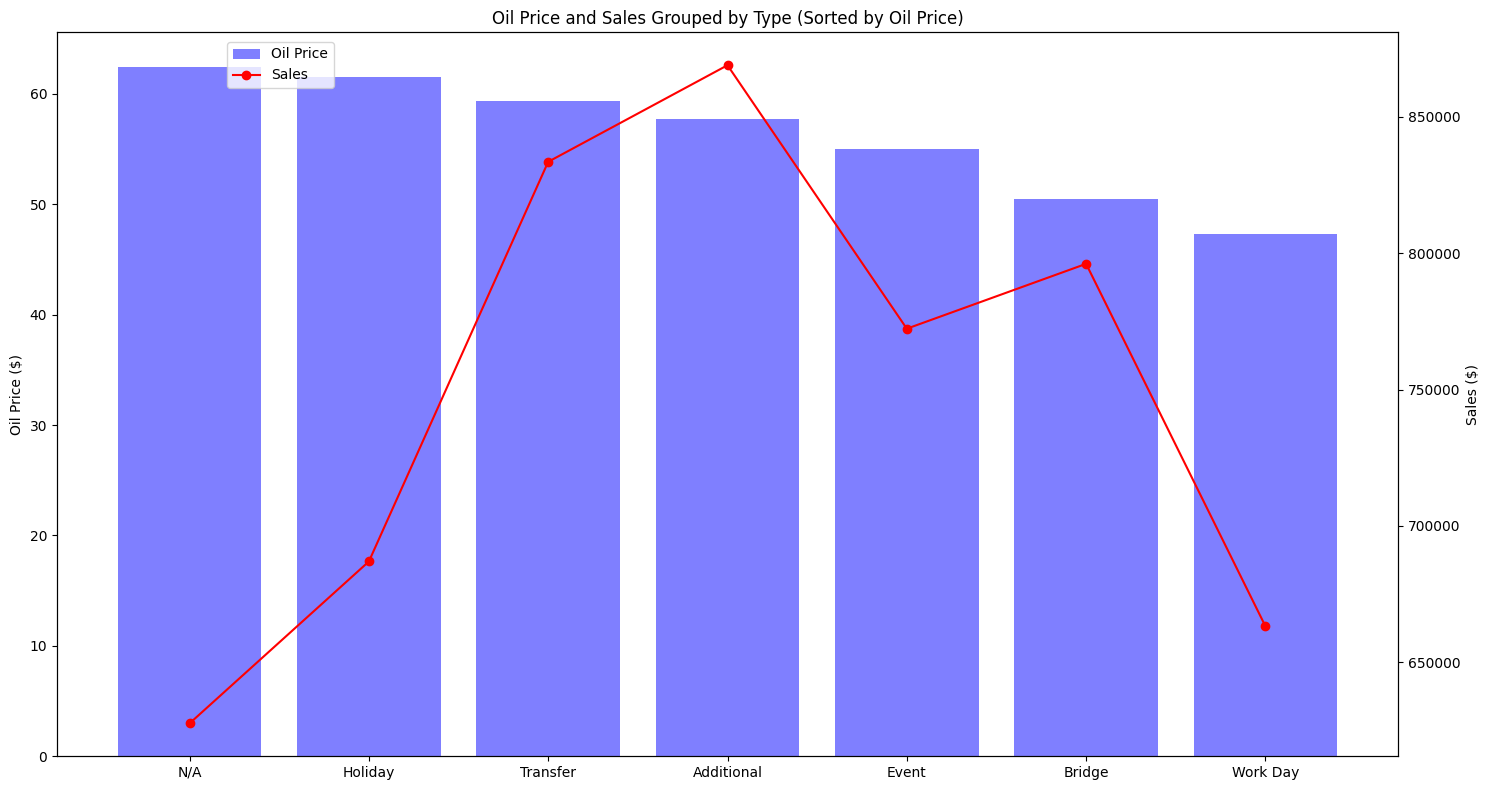

In [147]:


# Data
data = {
    'type': ['Additional', 'Bridge', 'Event', 'Holiday', 'N/A', 'Transfer', 'Work Day'],
    'oil_price': [57.67, 50.46, 55.02, 61.51, 62.44, 59.38, 47.26],
    'sales': [868954.74, 796110.02, 772317.62, 686935.02, 627547.66, 833536.04, 663184.71]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Sorting DataFrame by oil prices
df_sorted = df.sort_values(by='oil_price',ascending=False)

# Create figure and axes
fig, ax1 = plt.subplots()

# Plotting oil prices
ax1.bar(df_sorted['type'], df_sorted['oil_price'], color='b', alpha=0.5, label='Oil Price')
ax1.set_ylabel('Oil Price ($)')
ax1.tick_params(axis='y')

# Creating a secondary y-axis for sales
ax2 = ax1.twinx()
ax2.plot(df_sorted['type'], df_sorted['sales'], color='r', marker='o', label='Sales')
ax2.set_ylabel('Sales ($)')
ax2.tick_params(axis='y')

# Adding legend
fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.95))

# Title and labels
plt.title('Oil Price and Sales Grouped by Type (Sorted by Oil Price)')
plt.xlabel('Type')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


6. What analysis can we get from the date and its extractable features?

In [148]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [149]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [150]:
# Check for missing values
print("\nMissing values:")
print(original_df.isnull().sum())


Missing values:
store_nbr      0
family         0
sales          0
onpromotion    0
month_name     0
month          0
year           0
day            0
sales_date     0
dtype: int64


In [151]:
# Explore data types
print("\nData types:")
print(original_df.dtypes)


Data types:
store_nbr               int64
family                 object
sales                 float64
onpromotion           float64
month_name             object
month                   int32
year                    int32
day                     int32
sales_date     datetime64[ns]
dtype: object


In [152]:
# 2. Data Preparation
# Convert 'sales_date' column to datetime format
original_df['sales_date'] = pd.to_datetime(original_df['sales_date'])

In [153]:
# Extract relevant time features
original_df['year'] = original_df['sales_date'].dt.year
original_df['month'] = original_df['sales_date'].dt.month
original_df['day'] = original_df['sales_date'].dt.day

In [154]:
# 3. Daily Sales Analysis
# Calculate total daily sales
daily_sales = original_df.groupby('sales_date')['sales'].sum()

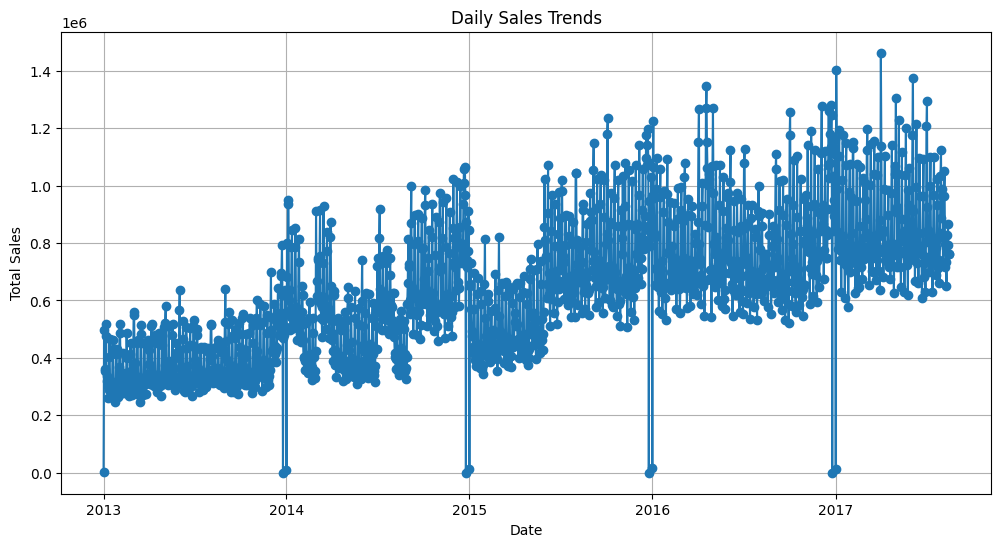

In [155]:

# Visualize daily sales trends over time
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values, marker='o', linestyle='-')
plt.title('Daily Sales Trends')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [156]:
# 4. Monthly Sales Analysis
# Calculate total monthly sales
monthly_sales = original_df.groupby(['year', 'month'])['sales'].sum()

In [157]:
# 4. Monthly Sales Analysis
# Calculate total monthly sales
monthly_sales = original_df.groupby(['year', 'month'])['sales'].sum()

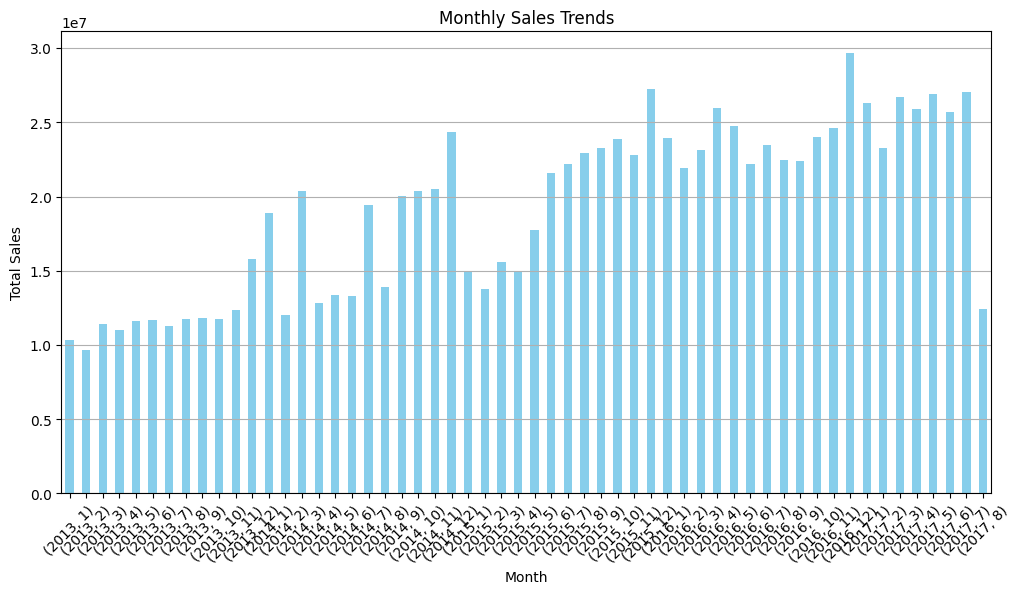

In [158]:
# Visualize monthly sales trends over time
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [159]:

# 5. Quarterly Sales Analysis (Optional)
# Calculate total quarterly sales
quarterly_sales = original_df.groupby(['year', pd.PeriodIndex(original_df['sales_date'], freq='Q')])['sales'].sum()

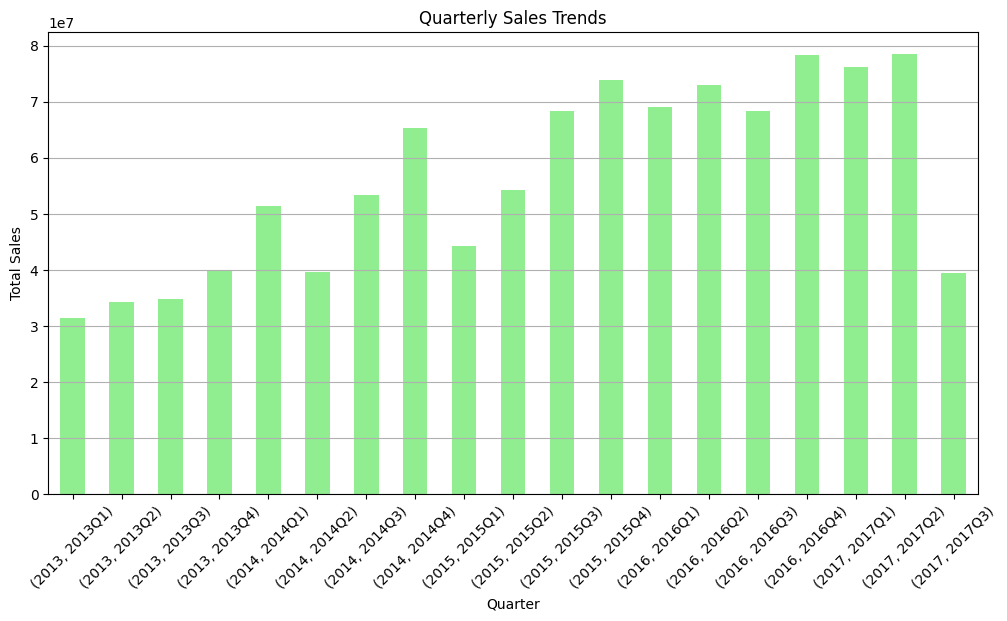

In [160]:
# Visualize quarterly sales trends over time
plt.figure(figsize=(12, 6))
quarterly_sales.plot(kind='bar', color='lightgreen')
plt.title('Quarterly Sales Trends')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [161]:
# 6. Yearly Sales Analysis
# Calculate total yearly sales
yearly_sales = original_df.groupby('year')['sales'].sum()

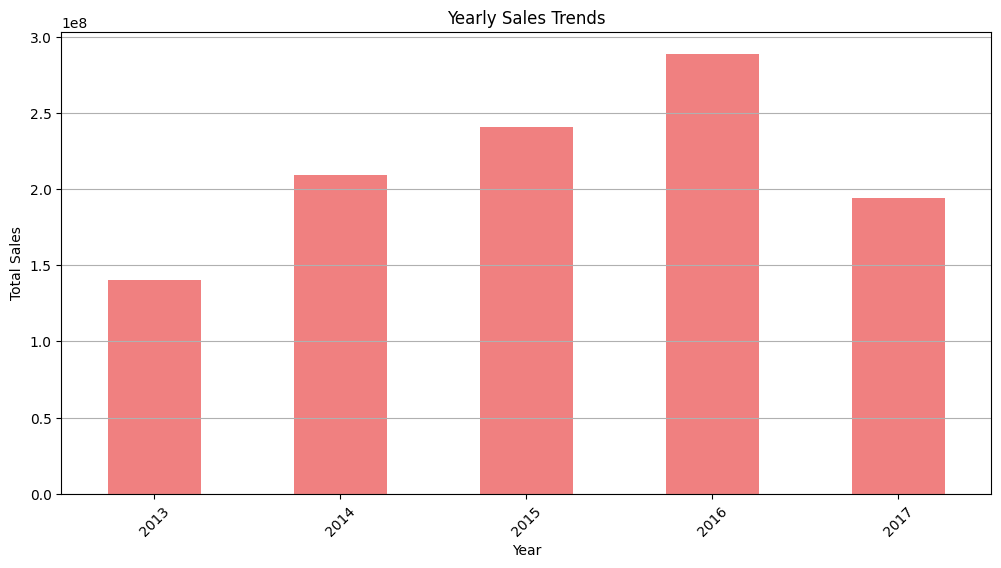

In [162]:



# Visualize yearly sales trends over time
plt.figure(figsize=(12, 6))
yearly_sales.plot(kind='bar', color='lightcoral')
plt.title('Yearly Sales Trends')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

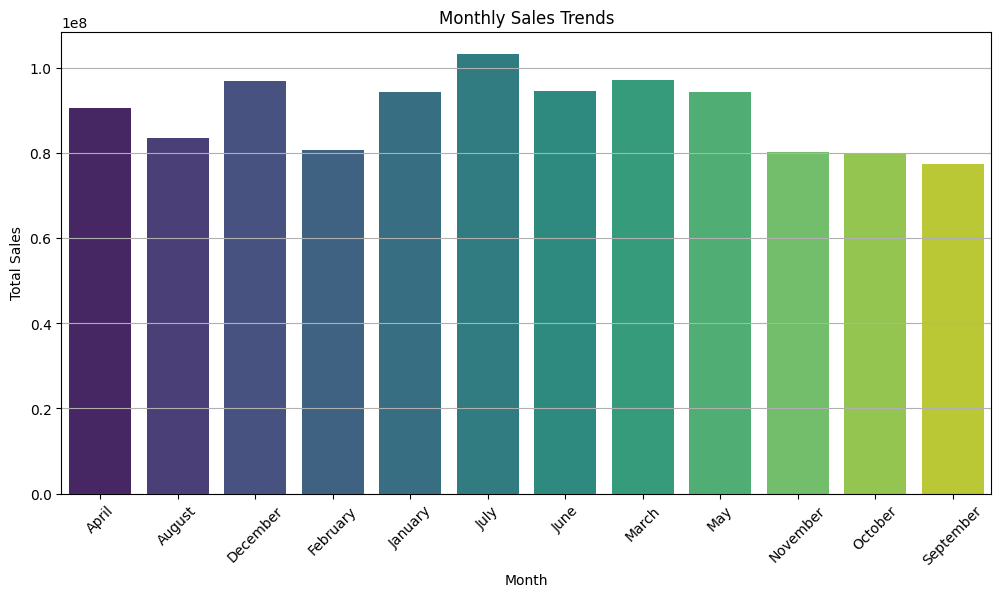

In [163]:

# 3. Monthly Sales Analysis
# Calculate total sales for each month
monthly_sales = original_df.groupby('month_name')['sales'].sum().reset_index()

# Visualize monthly sales trends
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales, x='month_name', y='sales', palette='viridis')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

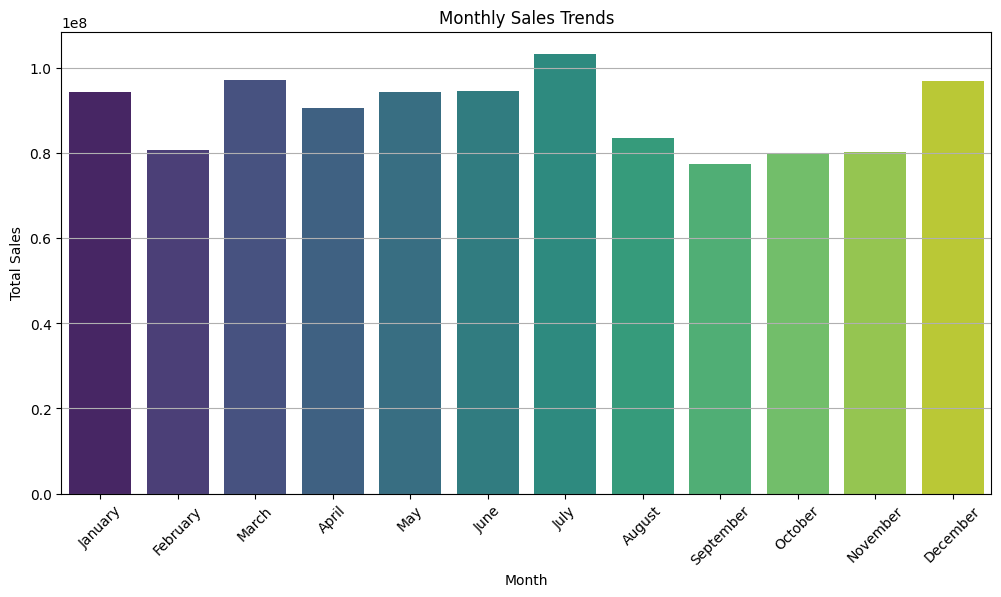

In [164]:

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Calculate total sales for each month
monthly_sales = original_df.groupby('month_name')['sales'].sum().reindex(month_order).reset_index()

# Visualize monthly sales trends
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales, x='month_name', y='sales', palette='viridis', order=month_order)
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


7. Which product family and stores did the promotions affect?

In [165]:
# Filter DataFrame to include only rows where promotions were active
promotions_df = original_df[original_df['onpromotion'] == 1]

# Get unique product families and stores affected by promotions
affected_families = promotions_df['family'].unique()
affected_stores = promotions_df['store_nbr'].unique()

print("Product families affected by promotions:", affected_families)
print('%'*80)
print("Stores affected by promotions:", affected_stores)


Product families affected by promotions: ['POULTRY' 'GROCERY I' 'BREAD/BAKERY' 'FROZEN FOODS' 'CLEANING'
 'BEVERAGES' 'EGGS' 'PREPARED FOODS' 'DAIRY' 'DELI' 'MEATS'
 'HOME APPLIANCES' 'PERSONAL CARE' 'SEAFOOD' 'LINGERIE' 'PRODUCE'
 'LAWN AND GARDEN' 'BEAUTY' 'AUTOMOTIVE' 'LIQUOR,WINE,BEER' 'GROCERY II'
 'HARDWARE' 'HOME CARE' 'PLAYERS AND ELECTRONICS' 'CELEBRATION'
 'HOME AND KITCHEN I' 'LADIESWEAR' 'HOME AND KITCHEN II' 'PET SUPPLIES'
 'MAGAZINES' 'SCHOOL AND OFFICE SUPPLIES' 'BABY CARE']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Stores affected by promotions: [ 9 39 18 28  6  3  2  8 38 41 23 12 10 13 15 14 16 33 30 19 17 35 43 40
 32 11 54 34 31 36  7 48 37 27  5 45 25 26  4 53 50 46 47 49 44  1 51 24
 20 29 21 42 22 52]


In [166]:
# Merge train data with promotions and analyze effect on product family and stores

promotion_effect = original_df.groupby(['family', 'store_nbr'])['onpromotion'].sum().reset_index()
# Aggregate the effect of promotion on different product families
promotion_aggregated = promotion_effect.groupby('family')['onpromotion'].sum().reset_index()
# Sort by total promotions
promotion_aggregated = promotion_aggregated.sort_values(by='onpromotion', ascending=False)

promotion_aggregated.head()

,family,onpromotion
12,GROCERY I,1914801.00
30,PRODUCE,1117921.00
3,BEVERAGES,906958.00
8,DAIRY,728707.00
7,CLEANING,661157.00


In [167]:
# Merge train data with promotions and analyze effect on product family, stores, and sales
promotion_effect = original_df.groupby(['family', 'store_nbr'])[['onpromotion', 'sales']].sum().reset_index()

# Aggregate the effect of promotion on different product families and sales
promotion_aggregated = promotion_effect.groupby('family')[['onpromotion', 'sales']].sum().reset_index()

# Sort by total promotions
promotion_aggregated = promotion_aggregated.sort_values(by='onpromotion', ascending=False)

promotion_aggregated.head()


,family,onpromotion,sales
12,GROCERY I,1914801.00,343462734.89
30,PRODUCE,1117921.00,122704684.68
3,BEVERAGES,906958.00,216954486.00
8,DAIRY,728707.00,64487709.00
7,CLEANING,661157.00,97521289.00


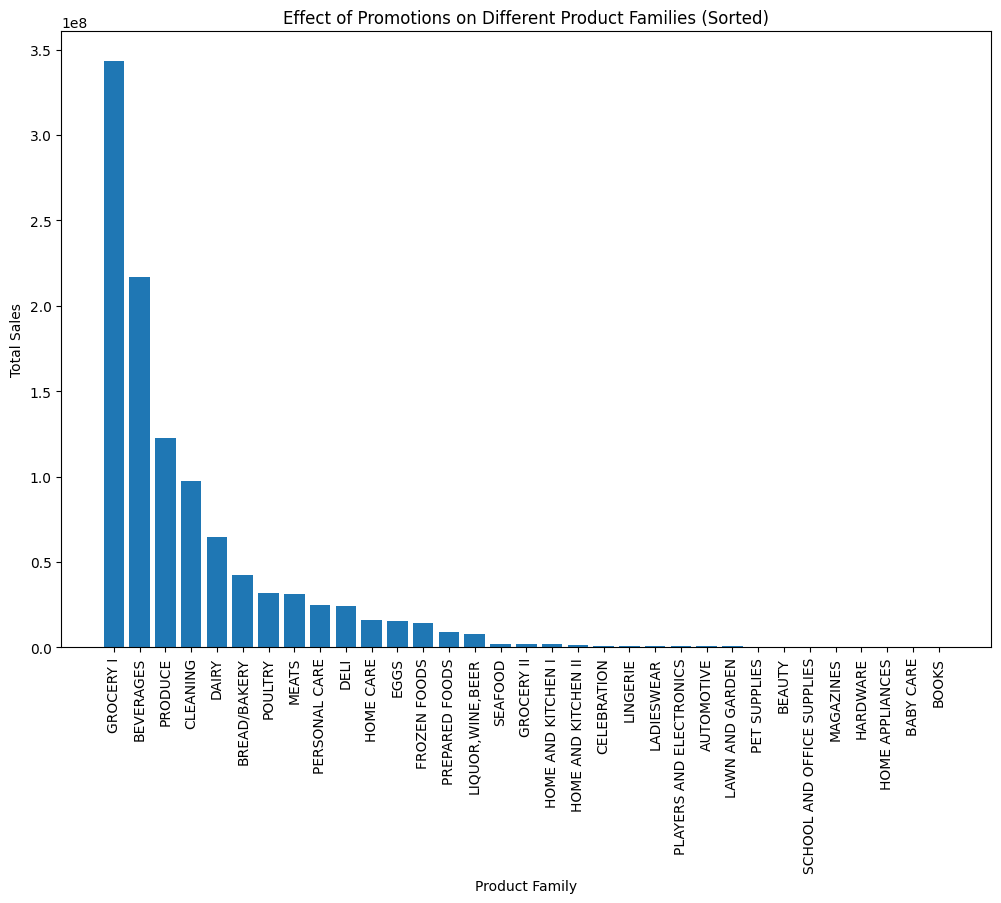

In [168]:
# Aggregate the effect of promotion on different product families
promotion_aggregated = promotion_effect.groupby('family')['sales'].sum().reset_index()

# Sort by total promotions
promotion_aggregated = promotion_aggregated.sort_values(by='sales', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(promotion_aggregated['family'], promotion_aggregated['sales'])
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.title('Effect of Promotions on Different Product Families (Sorted)')
plt.xticks(rotation=90)
plt.show()

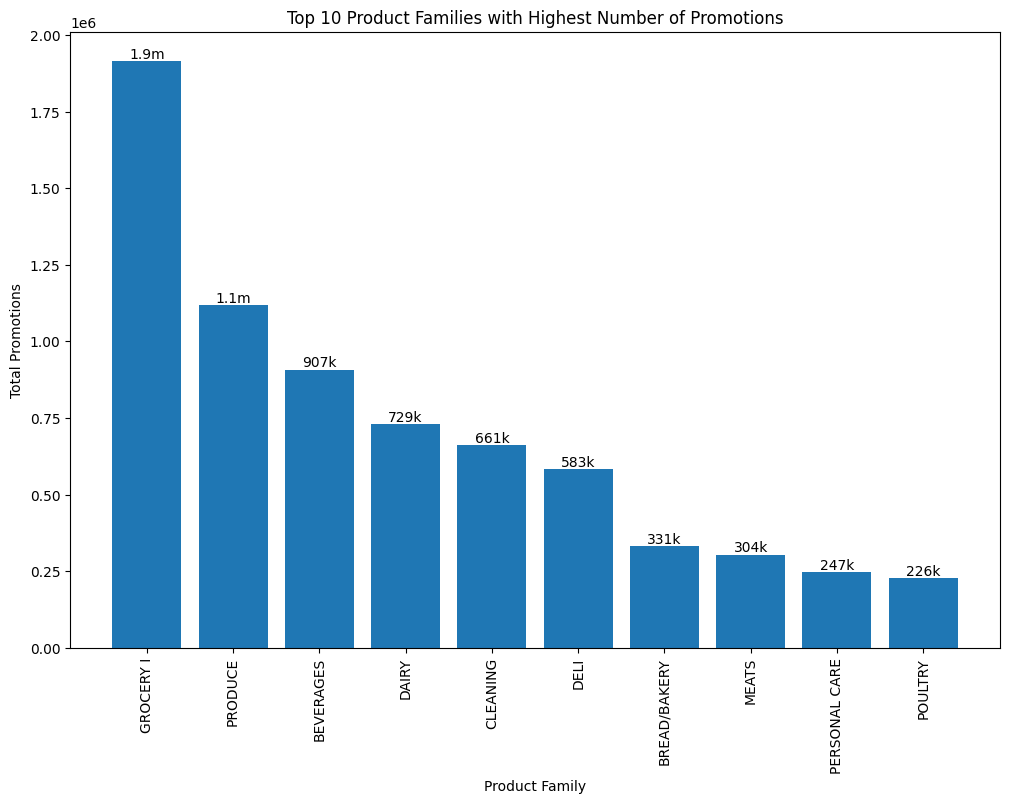

In [169]:


# Function to format numbers
def format_number(num):
    if num >= 1e6:
        return f'{num / 1e6:.1f}m'
    elif num >= 1e3:
        return f'{num / 1e3:.0f}k'
    else:
        return f'{num}'

# Aggregate the effect of promotion on different product families
promotion_aggregated = promotion_effect.groupby('family')['onpromotion'].sum().reset_index()

# Sort by total promotions
promotion_aggregated = promotion_aggregated.sort_values(by='onpromotion', ascending=False)

# Selecting top 10 product families
top_10 = promotion_aggregated.head(10)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(top_10['family'], top_10['onpromotion'])
plt.xlabel('Product Family')
plt.ylabel('Total Promotions')
plt.title('Top 10 Product Families with Highest Number of Promotions')
plt.xticks(rotation=90)

# Adding values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, format_number(yval), va='bottom', ha='center')

plt.show()



8. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

### Definitions
- **Mean Squared Error (MSE):** Measures the average squared difference between actual and predicted values.It is sensitive to large errors due to squaring.

- **Root Mean Squared Error (RMSE):** The square root of MSE, providing error in the same unit as the target variable.It Balances error sensitivity and interpretability.

- **Mean Absolute Error (MAE):** Measures the average absolute difference between actual and predicted values.
it is Less sensitive to outliers, treating all errors equally.

- **Root Mean Squared Logarithmic Error (RMSLE):** Measures the logarithmic difference between actual and predicted values.Focuses on relative differences, useful for exponential growth data.


### Differences
- **MSE vs. RMSE:** MSE penalizes larger errors more due to squaring whereas RMSE is more interpretable as it is in the same unit as the target variable.

- **MSE/RMSE vs. MAE:** MSE and RMSE are more sensitive to outliers because of squaring errors whereas
MAE treats all errors equally, making it more robust to outliers and often larger than RMSE in datasets with large deviations.
- **RMSLE vs. RMSE:** RMSLE is useful for data with large variations or exponential growth, focusing on relative errors whereas RMSE emphasizes larger errors in absolute terms.

### Why MAE is Often Greater
MAE tends to be greater than RMSE because it does not square errors, leading to higher absolute values in datasets with significant deviations. RMSE reduces the impact of smaller errors due to squaring, resulting in a lower overall error measure.

### Conclusion
Each error metric serves different purposes:

MAE is simple and robust against outliers.
MSE/RMSE emphasize larger errors, useful for highlighting significant deviations.
RMSLE is ideal for data with exponential growth or varying scales.
Choose the metric based on the specific needs and characteristics of your dataset.








10. Compare the sales for each month across the years and determine which month of which year had the highest sales.

Month and Year with the highest sales: (2016, 'December')
Highest Sales: 29640287.5793851


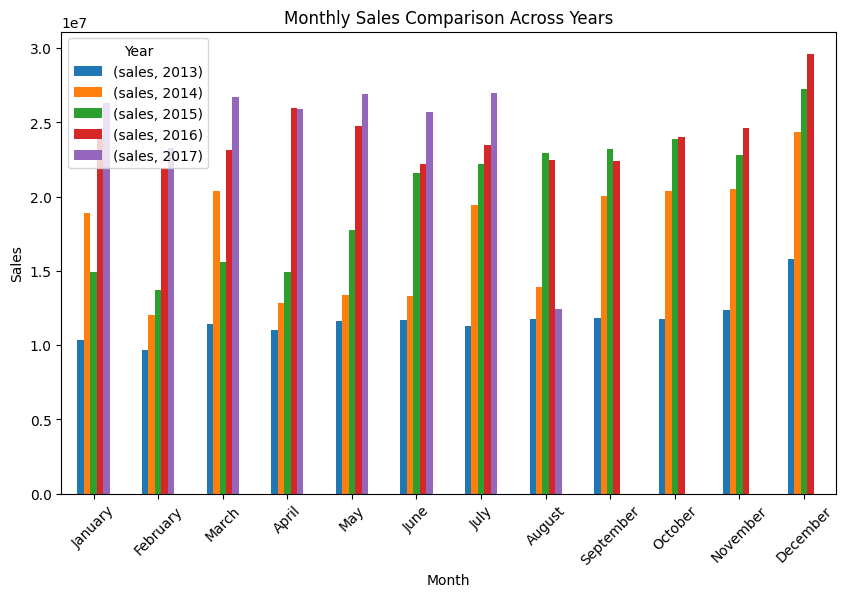

In [170]:


# Map numeric month values to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Replace numeric month values with month names
original_df['month_name'] = original_df['month'].map(month_names)

# Convert 'month_name' to a categorical data type with correct order
month_order = list(calendar.month_name)[1:]  # Get month names in order
original_df['month_name'] = pd.Categorical(original_df['month_name'], categories=month_order, ordered=True)

# Aggregate sales by month and year
monthly_sales = original_df.groupby(['year', 'month_name']).agg({'sales': 'sum'})

# Find the month and year with the highest sales
max_sales_month = monthly_sales['sales'].idxmax()
max_sales = monthly_sales.loc[max_sales_month, 'sales']

print("Month and Year with the highest sales:", max_sales_month)
print("Highest Sales:", max_sales)

# Plotting monthly sales
monthly_sales.unstack(level=0).plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Sales Comparison Across Years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.show()



## Hypothesis Testing

Null Hypothesis (H0): The promotional activities have a significant impact on store sales for Corporation Favorita.

Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales for Corporation Favorita.

In [171]:
# Extract the relevant variables for the hypothesis test
promo_sales = merged_df[merged_df['onpromotion'] == 1]['sales']
non_promo_sales = merged_df[merged_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)




In [172]:


# Extract the relevant variables for the hypothesis test
promo_sales = merged_df[merged_df['onpromotion'] == 1]['sales']
non_promo_sales = merged_df[merged_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare sales between promotional and non-promotional periods
t_statistic, p_value = ttest_ind(promo_sales, non_promo_sales)

# Print the test result
print("Hypothesis Testing for Promotional Activities:")
print("Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.")
print("Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.")
print("-" * 50)
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print("=" * 50)
if p_value < 0.05:
    print("Reject the null hypothesis. Promotional activities have a significant impact on store sales at Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. Promotional activities do not have a significant impact on store sales at Corporation Favorita.")

Hypothesis Testing for Promotional Activities:
Null Hypothesis (H0): The promotional activities do not have a significant impact on store sales.
Alternative Hypothesis (H1): The promotional activities have a significant impact on store sales.
--------------------------------------------------
Test Statistic: 197.71547182383821
P-value: 0.0
Reject the null hypothesis. Promotional activities have a significant impact on store sales at Corporation Favorita.


Based on the hypothesis test, we obtained a very low p-value of 0.0. This indicates strong evidence to reject the null hypothesis. Therefore, we can conclude that promotional activities have a significant impact on store sales for Corporation Favorita. The test statistic of 68.22 also suggests a substantial difference in sales between promotional and non-promotional periods. These results support the notion that promotional activities play a crucial role in driving store sales.

## Data preparation

### Make Data Stationary

1. Detrending: Differencing and seasonal differencing
2. Rolling stats-Moving Average
3. Transformation: log, sqrt,cbrt+differencin

In [173]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [174]:
# Convert 'sales_date' to day names and replace the original column
original_df['sales_date'] = original_df['sales_date'].dt.day_name()

# Rename the column to 'sales_day'
original_df.rename(columns={'sales_date': 'day_name'}, inplace=True)

# Print the updated DataFrame



In [175]:

original_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,Tuesday
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Tuesday
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,Tuesday
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday
...,...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,15,Tuesday
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,15,Tuesday
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,15,Tuesday


In [176]:
complete_df = original_df.copy()

In [177]:
complete_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,Tuesday
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Tuesday
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,Tuesday
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday


In [178]:
#I will create a sales_diff wich is a defferenced sales column
complete_df['sales_diff'] = complete_df['sales'] - complete_df['sales'].shift(1)
complete_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,sales_diff
date,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,NaN
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,Tuesday,0.00
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Tuesday,0.00
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,0.00
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,0.00
...,...,...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,15,Tuesday,147.05
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,15,Tuesday,-169.52
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,15,Tuesday,0.00


In [179]:
#Difference Transformations
# First Difference
complete_df['first_difference'] = complete_df['sales'].diff()


In [180]:
complete_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,sales_diff,first_difference
date,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,NaN,NaN
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,15,Tuesday,147.05,147.05
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,15,Tuesday,-169.52,-169.52
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,15,Tuesday,0.00,0.00


In [181]:
# Seasonal Difference
seasonal_difference = complete_df['sales'].diff(periods=12)  # Assuming a yearly seasonality
complete_df['seasonal_difference'] = seasonal_difference

In [182]:
#Log Difference
complete_df['log_difference'] = np.log(complete_df['sales']) - np.log(complete_df['sales'].shift(1))


In [183]:
complete_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,sales_diff,first_difference,seasonal_difference,log_difference
date,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,NaN,NaN,NaN,NaN
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00,NaN,NaN
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00,NaN,NaN
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00,NaN,NaN
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,15,Tuesday,147.05,147.05,-111.48,1.91
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,15,Tuesday,-169.52,-169.52,-1.00,-4.05
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,15,Tuesday,0.00,0.00,-177.11,0.00


In [184]:
differenced_df = complete_df.groupby([complete_df.index])['sales_diff'].sum().reset_index()
differenced_df.set_index('date', inplace =True)
differenced_df.head()

,sales_diff
date,
2013-01-01,37.85
2013-01-02,-35.85
2013-01-03,-2.00
2013-01-04,0.00
2013-01-05,-0.00


In [185]:
seasonal_differenced_df = complete_df.groupby([complete_df.index])['seasonal_difference'].sum().reset_index()
seasonal_differenced_df.set_index('date', inplace =True)
seasonal_differenced_df.head()

,seasonal_difference
date,
2013-01-01,216.28
2013-01-02,367.30
2013-01-03,21.95
2013-01-04,222.84
2013-01-05,165.86


In [186]:
log_differenced_df = complete_df.groupby([complete_df.index])['log_difference'].sum().reset_index()
log_differenced_df.set_index('date', inplace =True)
log_differenced_df.head()

,log_difference
date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN


<Axes: xlabel='date'>

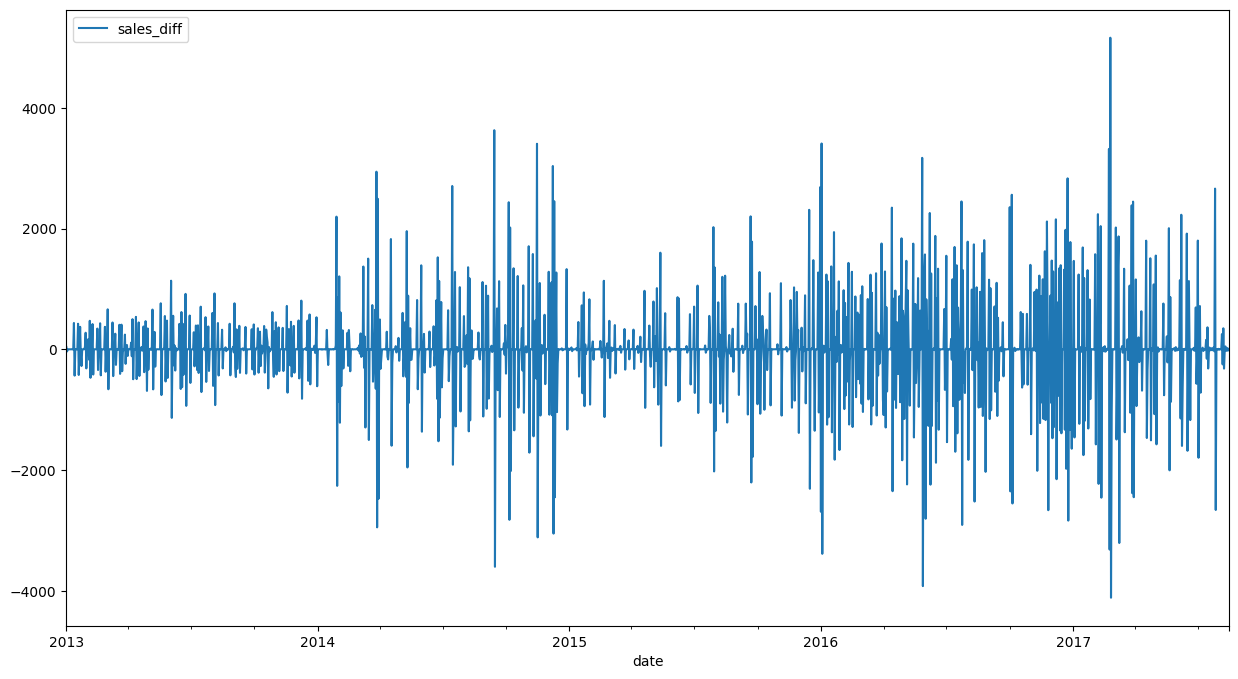

In [187]:
differenced_df.plot()

<Axes: xlabel='date'>

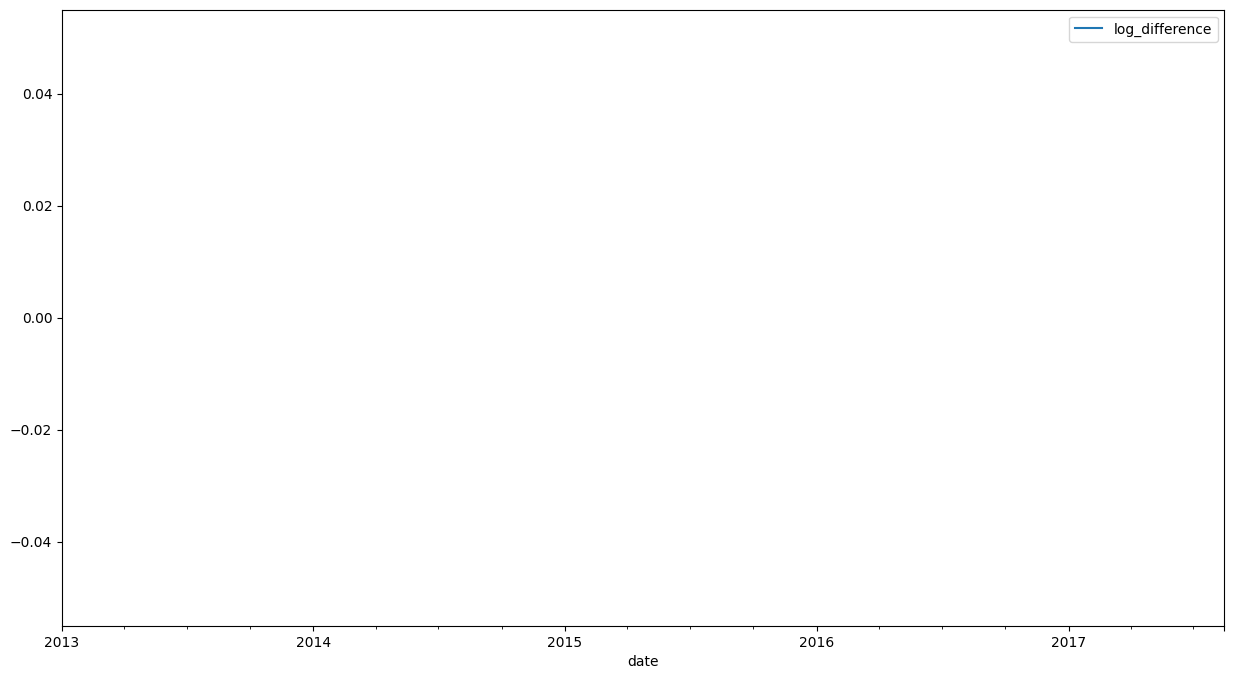

In [188]:
log_differenced_df.plot()

In [189]:
complete_df['sales_diff-2'] = complete_df['sales_diff'] - complete_df['sales_diff'].shift(1)

In [190]:
differenced2_df = complete_df.groupby([complete_df.index])['sales_diff-2'].sum().reset_index()
differenced2_df.set_index('date', inplace =True)
differenced2_df.head()

,sales_diff-2
date,
2013-01-01,37.85
2013-01-02,-280.55
2013-01-03,242.70
2013-01-04,0.00
2013-01-05,-0.00


In [191]:
result = adfuller(differenced_df)

- Stationarity before differencing

In [192]:
#Use ADF to calculate stationarity in sales
result = adfuller(df_downsampled['sales'])
print('ADF Statistic:',result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -1.481750917756024
p-value: 0.5425188110982654
Data is not stationary


- Stationarity after first differencing

In [193]:
#Use ADF to calculate stationarity in sales
result = adfuller(differenced_df['sales_diff'])
print('ADF Statistic:',result[0])
print('p-value:', f'{result[1]:.30f}')
if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -15.058491078197
p-value: 0.000000000000000000000000000908
Data is stationary


In [194]:
result

(-15.058491078197,
 9.076562919333222e-28,
 23,
 1664,
 {'1%': -3.4342859473725906,
  '5%': -2.8632784969542016,
  '10%': -2.56769553371452},
 25705.759958787683)

In [195]:
#Use ADF to calculate stationarity in sales
result = adfuller(seasonal_differenced_df['seasonal_difference'])
print('ADF Statistic:',result[0])
print('p-value:', f'{result[1]:.30f}')
if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -15.981055442805479
p-value: 0.000000000000000000000000000068
Data is stationary


In [196]:
result

(-15.981055442805479,
 6.834866899942485e-29,
 20,
 1667,
 {'1%': -3.43427885313169,
  '5%': -2.863275365507293,
  '10%': -2.5676938662645394},
 28791.824357048332)

In [197]:
differenced_df['moving_average_sales '] = differenced_df['sales_diff'].rolling(window = 30).mean()
differenced_df

,sales_diff,moving_average_sales
date,,
2013-01-01,37.85,NaN
2013-01-02,-35.85,NaN
2013-01-03,-2.00,NaN
2013-01-04,0.00,NaN
2013-01-05,-0.00,NaN
...,...,...
2017-08-11,-23.22,0.79
2017-08-12,-23.83,-5.20
2017-08-13,20.00,0.67


<Axes: xlabel='date'>

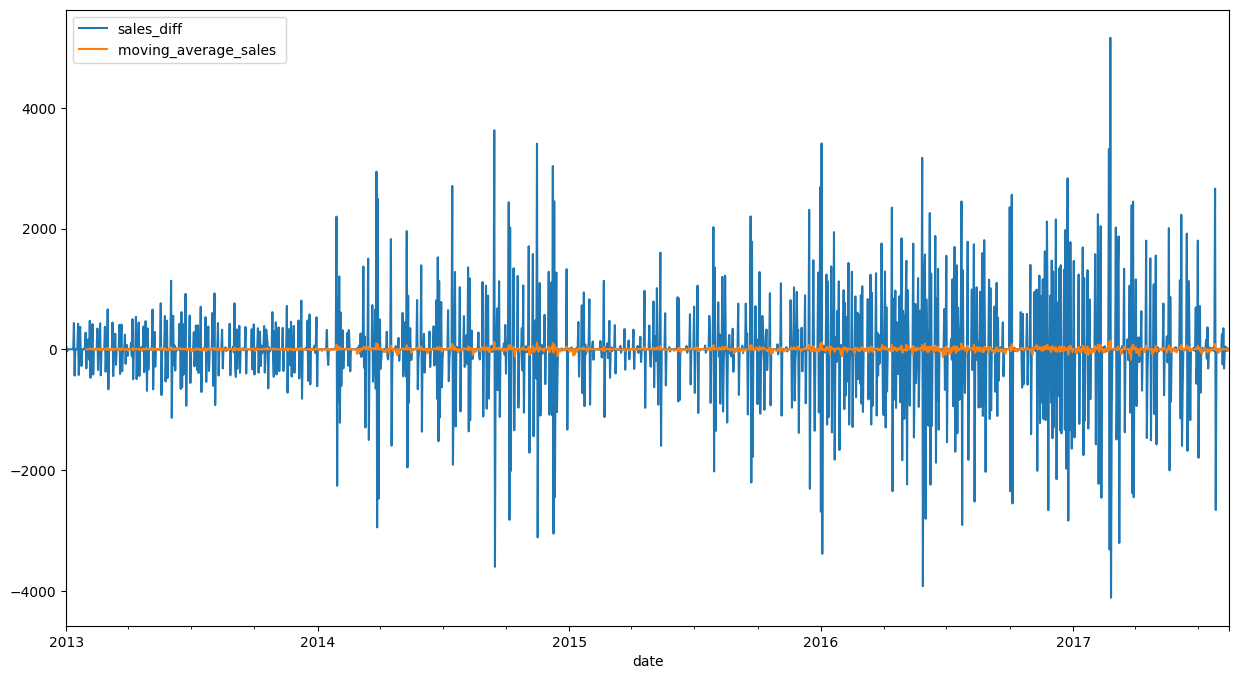

In [198]:
differenced_df.plot()

In [199]:
complete_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name,sales_diff,first_difference,seasonal_difference,log_difference,sales_diff-2
date,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Tuesday,NaN,NaN,NaN,NaN,NaN
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00,NaN,NaN,NaN
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00,NaN,NaN,0.00
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00,NaN,NaN,0.00
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,Tuesday,0.00,0.00,NaN,NaN,0.00


In [200]:
sum_daily_sales = complete_df.groupby('date')['sales'].sum()

# Assuming sum_daily_sales is the Series containing the sum of daily sales against date
sum_daily_sales_df = pd.DataFrame(sum_daily_sales)
sum_daily_sales_df.head()


,sales
date,
2013-01-01,2511.62
2013-01-02,496092.42
2013-01-03,361461.23
2013-01-04,354459.68
2013-01-05,477350.12


In [201]:
sum_daily_sales_df['moving_average_sales'] = sum_daily_sales_df['sales'].rolling(window =30).mean()
sum_daily_sales_df.head()

,sales,moving_average_sales
date,,
2013-01-01,2511.62,NaN
2013-01-02,496092.42,NaN
2013-01-03,361461.23,NaN
2013-01-04,354459.68,NaN
2013-01-05,477350.12,NaN


<Axes: xlabel='date'>

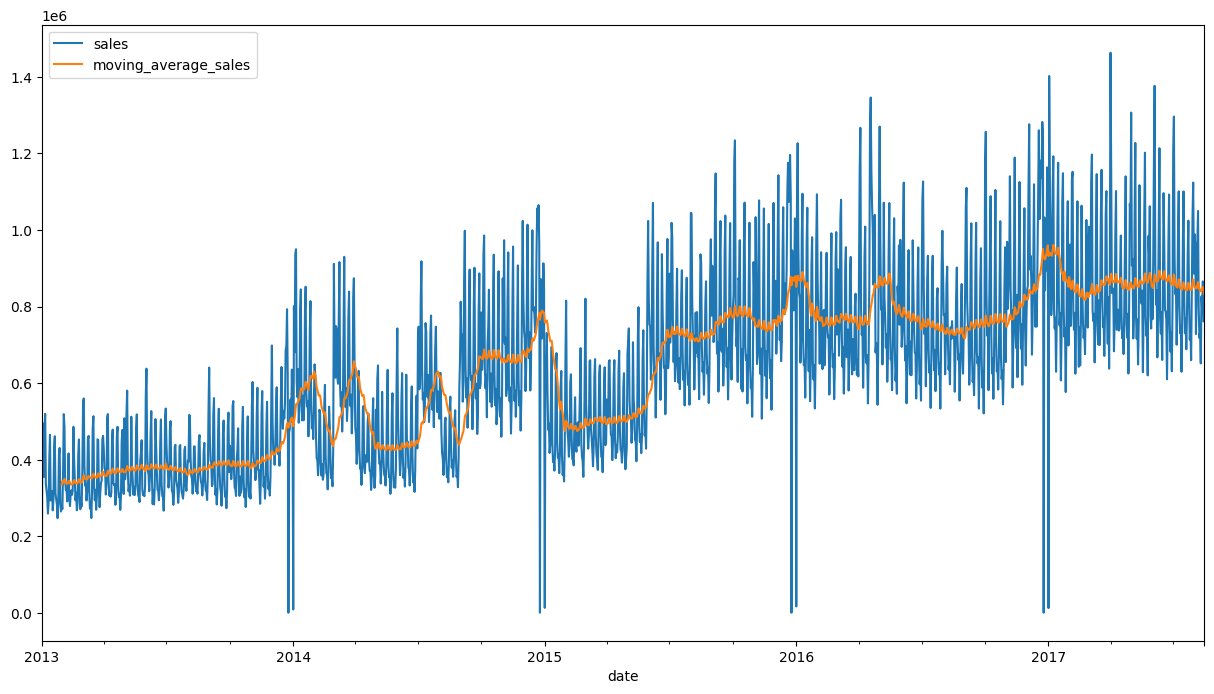

In [202]:
sum_daily_sales_df.plot()

### Statistical Model - SARIMA

1. Split the data into training and testing
2. Run SARIMA to get the optimal hyperparameters(p,d,q)
3. Fit the dataset to the model for training

In [203]:
sarima_df = differenced_df['sales_diff']

In [204]:

sarima_df = pd.DataFrame(sarima_df)

In [205]:
sarima_df.head()

,sales_diff
date,
2013-01-01,37.85
2013-01-02,-35.85
2013-01-03,-2.00
2013-01-04,0.00
2013-01-05,-0.00


In [206]:
sarima_df[sarima_df.index < '06-01-2017']

,sales_diff
date,
2013-01-01,37.85
2013-01-02,-35.85
2013-01-03,-2.00
2013-01-04,0.00
2013-01-05,-0.00
...,...
2017-05-27,14.00
2017-05-28,12.42
2017-05-29,-26.42


In [207]:
train = sarima_df.loc[sarima_df.index < '06-01-2017']
test = sarima_df.loc[sarima_df.index >= '06-01-2017']

In [208]:
test

,sales_diff
date,
2017-06-01,-16.85
2017-06-02,11.00
2017-06-03,-8.00
2017-06-04,-3.00
2017-06-05,1145.05
...,...
2017-08-11,-23.22
2017-08-12,-23.83
2017-08-13,20.00


In [209]:
train.size,test.size

(1612, 76)

In [210]:


sarima_model = auto_arima(
    train['sales_diff'],
    seasonal = False,
    m =7,
    stepwise = True
)
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1612
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -12432.020
Date:                Sat, 01 Jun 2024   AIC                          24872.040
Time:                        02:25:17   BIC                          24893.581
Sample:                    01-01-2013   HQIC                         24880.036
                         - 05-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0561      0.025     -2.223      0.026      -0.106      -0.007
ar.L2          0.0787      0.015      5.315      0.000       0.050       0.108
ma.L1         -0.9850      0.005   -215.130      0.0

In [211]:
print(sarima_model.order)
print(sarima_model.seasonal_order)

(2, 0, 1)
(0, 0, 0, 0)


In [212]:
sarima_model.fit(train['sales_diff'])

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [213]:
n_test_period = len(test)
forecast = sarima_model.predict(n_periods = n_test_period)

In [214]:
mae = mean_absolute_error(test['sales_diff'],forecast)
rmse = np.sqrt(mean_squared_error(test['sales_diff'], forecast))

print(mae)
print(rmse)

365.1771152506384
751.9680961475035


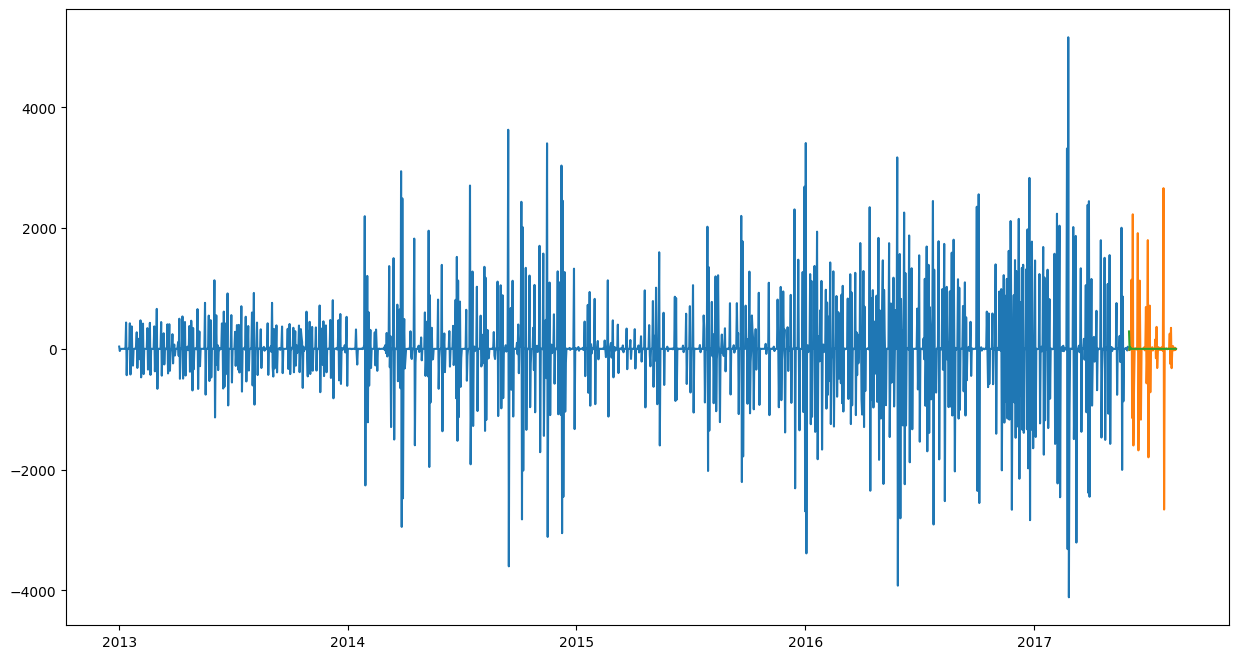

In [215]:
plt.plot(train['sales_diff'], label = 'Train Set')
plt.plot(test['sales_diff'], label = 'Test Set')
plt.plot(forecast, label = 'SARIMA Forecast')
plt.show()

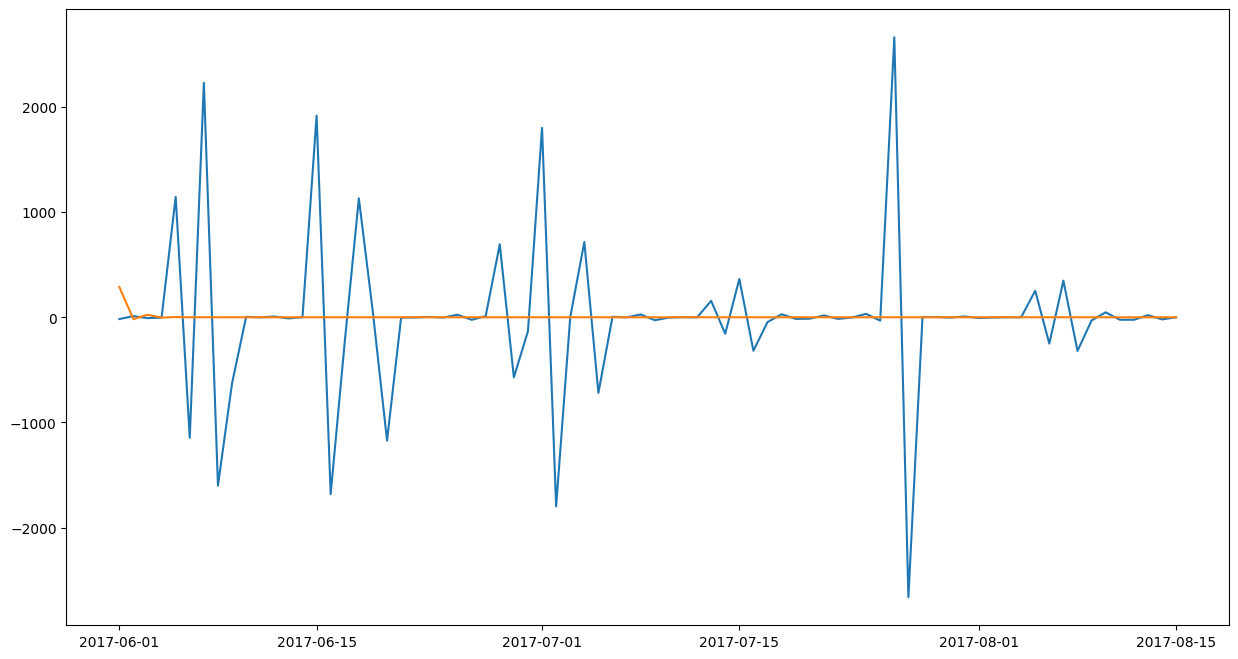

In [216]:
#plt.plot(train['sales_diff'], label = 'Train Set')
plt.plot(test['sales_diff'], label = 'Test Set')
plt.plot(forecast, label = 'SARIMA Forecast')
plt.show()

- I will diagnose and resolve issues with the SARIMA model producing flat forecasts.

1. I will check for stationarity

In [217]:
train_df = train
test_df = test

# Step 1: Check for stationarity
result = adfuller(train_df['sales_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -14.66042897683733
p-value: 3.388305210214606e-27


#### 2. Plot ACF and PACF: I will Visualize to help determine the order of AR and MA components.

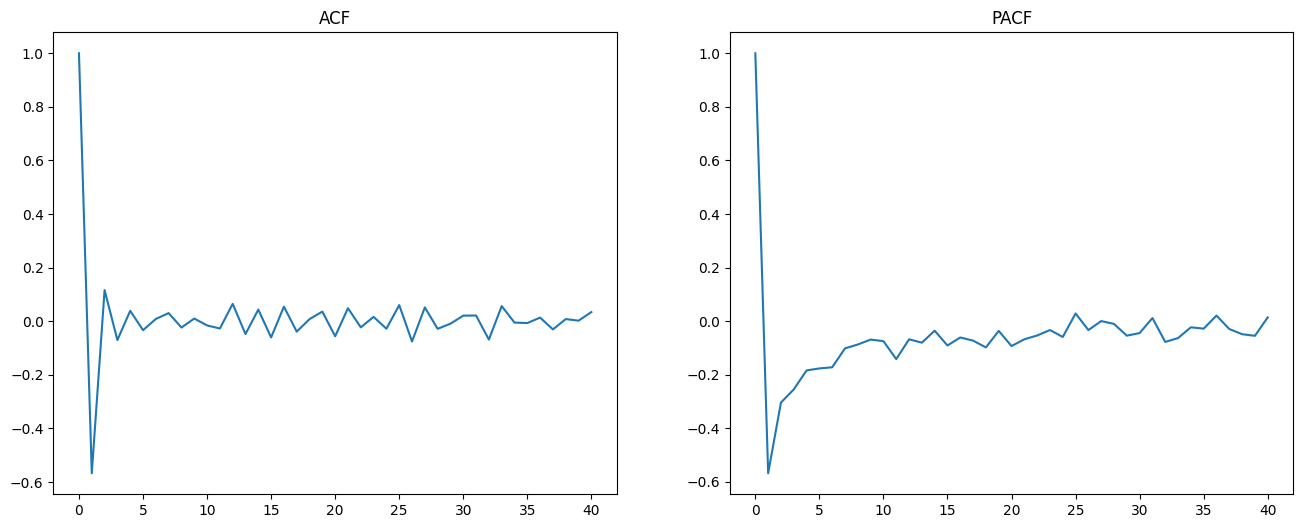

In [218]:

# Step 2: ACF and PACF plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(acf(train_df['sales_diff'], nlags=40))
ax[0].set_title('ACF')
ax[1].plot(pacf(train_df['sales_diff'], nlags=40))
ax[1].set_title('PACF')
plt.show()

#### 3. Grid Search for Optimal SARIMA Parameters: I will identify the best parameters for the SARIMA model.

In [219]:

# Step 3: Grid search for SARIMA parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
best_aic = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(train_df['sales_diff'],
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue 
        

print(f'Best SARIMA order: {best_order}')
print(f'Best seasonal order: {best_seasonal_order}')

#best_order = sarima_model.order
#best_seasonal_order = sarima_model.seasonal_order

Best SARIMA order: (1, 0, 1)
Best seasonal order: (1, 1, 1, 12)


#### 4. Fit the SARIMA Model: I will Fit the model on the training data.

In [220]:
# Step 4: Fit the best SARIMA model
model = SARIMAX(train_df['sales_diff'], order=best_order, seasonal_order=best_seasonal_order)
results = model.fit(disp=False)



#### 5. I will forecast using the fitted model and compare with the test data.

In [221]:
# Step 5: Forecast
pred = results.get_forecast(steps=len(test_df))
pred_ci = pred.conf_int()



### 6. I will visualize my forecast

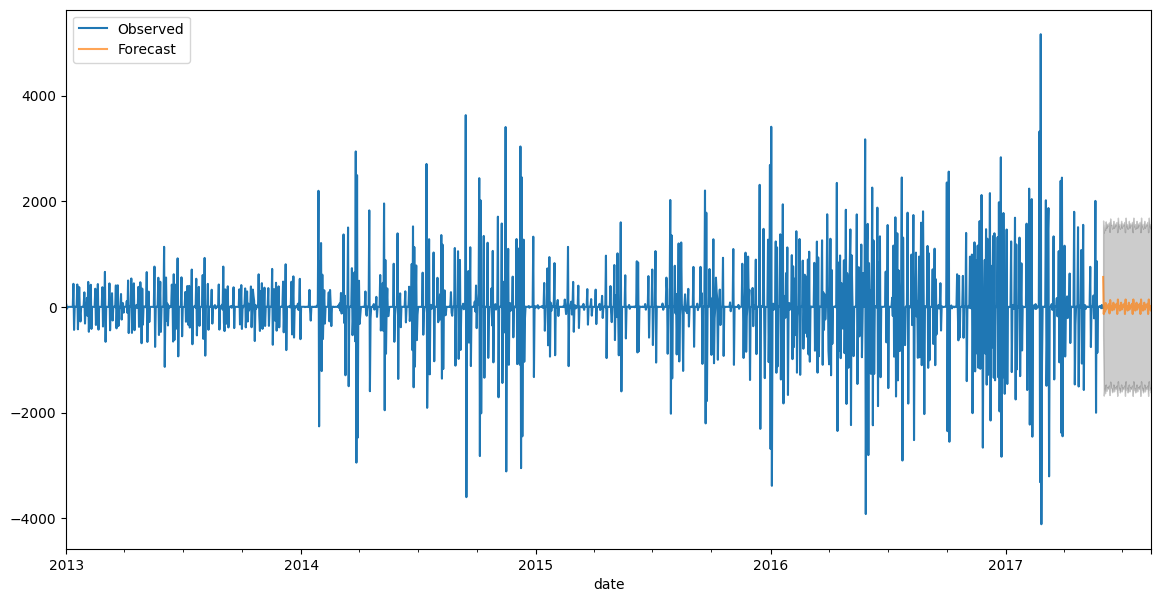

In [222]:

# Step 6: Plot the results
ax = train_df['sales_diff'].plot(label='Observed', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.2)
plt.legend()
plt.show()



In [223]:
pred.predicted_mean

2017-06-01    565.44
2017-06-02   -136.18
2017-06-03     -7.63
2017-06-04    -89.87
2017-06-05     73.37
               ...  
2017-08-11    139.67
2017-08-12    -25.19
2017-08-13     17.45
2017-08-14    -70.43
2017-08-15    -34.65
Freq: D, Name: predicted_mean, Length: 76, dtype: float64

In [224]:

# Convert the dictionary to a pandas Series
predicted_mean_series = pd.Series(pred.predicted_mean, name='predicted_mean')

# Convert the Series to a DataFrame
predicted_mean_df = predicted_mean_series.to_frame()

# To display the DataFrame
predicted_mean_df

,predicted_mean
2017-06-01,565.44
2017-06-02,-136.18
2017-06-03,-7.63
2017-06-04,-89.87
2017-06-05,73.37
...,...
2017-08-11,139.67
2017-08-12,-25.19
2017-08-13,17.45
2017-08-14,-70.43


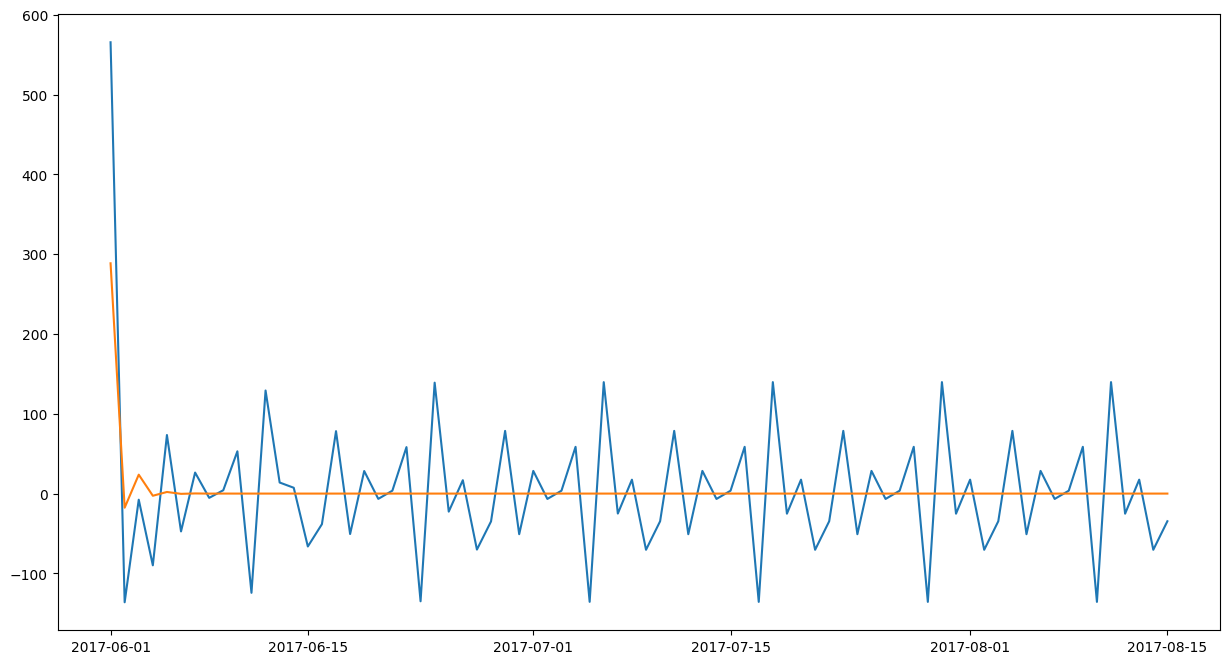

In [225]:
#plt.plot(train['sales_diff'], label = 'Train Set')
plt.plot(predicted_mean_df['predicted_mean'], label = 'Test Set')
plt.plot(forecast, label = 'SARIMA Forecast')
plt.show()

- Evaluating models performance 

In [226]:
# Evaluate the model's performance
test_values = test_df['sales_diff']
forecasted_values = predicted_mean_df['predicted_mean']
mse = ((forecasted_values - test_values) ** 2).mean()
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 569627.4406015504


In [227]:


# Evaluate the model's performance
test_values = test_df['sales_diff']
forecasted_values = predicted_mean_df['predicted_mean']

# Calculate Mean Squared Error (MSE)
mse = ((forecasted_values - test_values) ** 2).mean()
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
# To avoid taking the log of zero, we add 1 to the values (assuming non-negative sales values)
rmsle = np.sqrt(np.mean((np.log1p(forecasted_values) - np.log1p(test_values)) ** 2))
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')


Mean Squared Error (MSE): 569627.4406015504
Root Mean Squared Error (RMSE): 754.7366697077533
Root Mean Squared Logarithmic Error (RMSLE): 2.8803078272471394


Overall Depiction of the Analysis
Accuracy Concerns: The high values of MSE, RMSE, and RMSLE indicate that the model's predictions are not very accurate. There are significant errors both in absolute terms (RMSE) and relative terms (RMSLE).

Potential Issues:

Outliers or Variability: The large errors could be due to outliers or high variability in the sales data. The model might be sensitive to these outliers, resulting in poor performance metrics.
Model Fit: The model may not be the best fit for the data. Consider trying different models or tuning the existing model to improve accuracy.
Implications for Business Decisions: If the goal is to use this model for making business decisions, the current performance metrics suggest that the model needs improvement. High prediction errors could lead to incorrect decisions, affecting inventory management, sales forecasting, and strategic planning.

Next Steps:

Model Tuning: I will try using more complex models to capture the patterns in the data better.


Alternative Time Series Models
If SARIMA is not performing well, I will explore other time series models.

Exponential Smoothing (ETS):

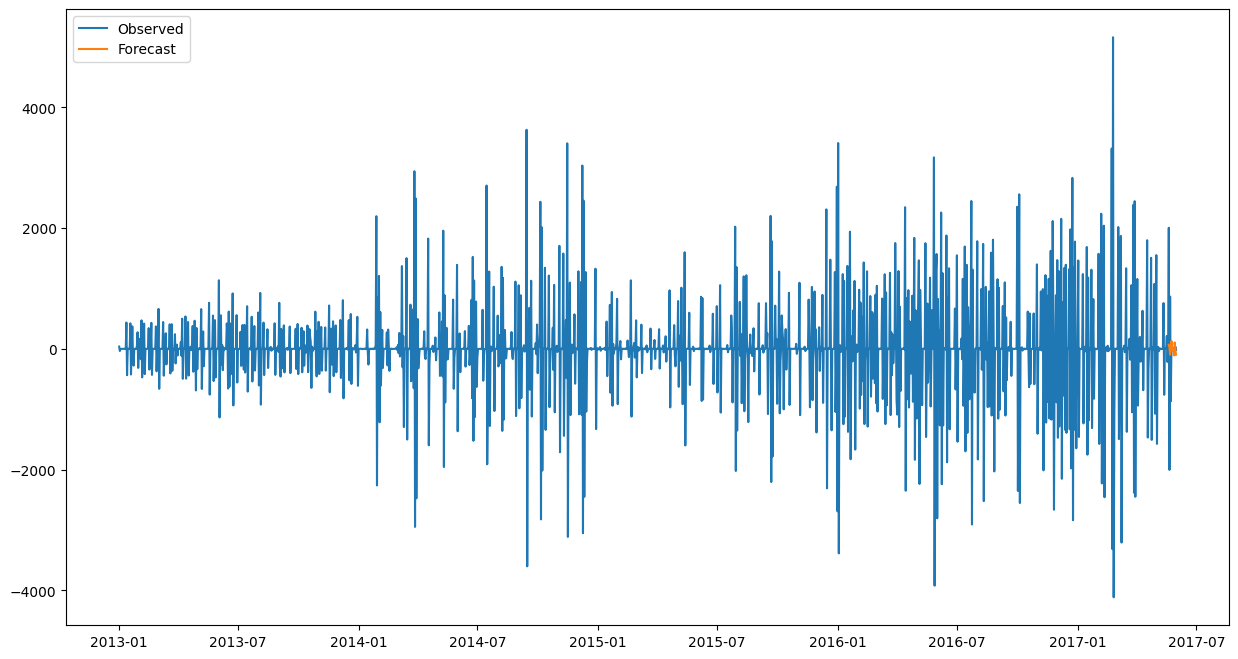

In [228]:


model = ExponentialSmoothing(train_df['sales_diff'],
                             seasonal='add',
                             seasonal_periods=12)
results = model.fit()

# Forecasting
forecast_steps = 12
forecast = results.forecast(steps=forecast_steps)

# Plot results
plt.plot(train_df['sales_diff'], label='Observed')
plt.plot(train_df.index[-forecast_steps:], forecast, label='Forecast')
plt.legend()
plt.show()


In [229]:
df = original_df.copy()

In [230]:
df_sample = df.sample(frac=0.1, random_state=1)

# View the sampled DataFrame
df_sample

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name
date,,,,,,,,,
2017-02-02,27,FROZEN FOODS,68.00,2.00,February,2,2017,2,Thursday
2013-11-30,13,LADIESWEAR,0.00,0.00,November,11,2013,30,Saturday
2013-07-31,21,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,July,7,2013,31,Wednesday
2017-06-16,6,PET SUPPLIES,10.00,0.00,June,6,2017,16,Friday
2013-08-19,24,POULTRY,279.72,0.00,August,8,2013,19,Monday
...,...,...,...,...,...,...,...,...,...
2015-08-18,46,HOME AND KITCHEN II,16.00,0.00,August,8,2015,18,Tuesday
2016-12-14,27,PET SUPPLIES,7.00,0.00,December,12,2016,14,Wednesday
2016-04-09,13,LINGERIE,1.00,0.00,April,4,2016,9,Saturday


Define the evaluate_models Function:
This function preprocesses the data, trains the models, and outputs evaluation metrics in a table format.

python

Define the Models to be Evaluated:

Load  Data:
A 10% sample will be used 

In [231]:
# sgb_df = pd.read_csv('your_data.csv')
# Using a sample for demonstration
df_sample = original_df.sample(frac=0.1, random_state=1)


Evaluate the Models:

In [232]:
sgb_df = df_sample.copy()
sgb_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name
date,,,,,,,,,
2017-02-02,27,FROZEN FOODS,68.00,2.00,February,2,2017,2,Thursday
2013-11-30,13,LADIESWEAR,0.00,0.00,November,11,2013,30,Saturday
2013-07-31,21,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,July,7,2013,31,Wednesday
2017-06-16,6,PET SUPPLIES,10.00,0.00,June,6,2017,16,Friday
2013-08-19,24,POULTRY,279.72,0.00,August,8,2013,19,Monday


#### Data Preparation

### Feature Engineering Steps

#### Date Features

- Extracts `day_of_week`, `week_of_year`, and `quarter` from the date index.

#### Encoding Categorical Variables

- One-hot encodes the `family` column.
- Label encodes the `month_name` and `day_name` columns.

#### Interaction Features

- Creates an interaction feature `sales_onpromotion` by multiplying `sales` and `onpromotion`.

#### Lag Features

- Creates lag features for `sales` and `onpromotion`.

#### Aggregation Features

- Aggregates sales data by store and month to create `monthly_sales`.
```


In [233]:
sgb_df['onpromotion'].unique()

array([  2.,   0.,  10.,   1.,   7.,   5.,  18.,   3.,  80.,  13.,  77.,
        28.,  56.,  44.,  30.,   8.,  11.,  19.,  12.,  70.,  32.,  48.,
         9.,   4.,  17.,   6.,  15.,  34.,  41.,  21.,  68.,  26.,  42.,
        16.,  23.,  22.,  60.,  33.,  65.,  31., 107.,  62.,  24.,  64.,
        14.,  46., 152.,  25.,  52., 186.,  45.,  92.,  20.,  59., 110.,
        47.,  72.,  51.,  39.,  57.,  35.,  53.,  58., 204.,  29.,  50.,
       133.,  37.,  38.,  55., 135., 106.,  89.,  36.,  27., 128., 178.,
        43.,  71., 199.,  69.,  85.,  63.,  40., 123., 167.,  81., 109.,
        73.,  84.,  66., 118.,  97.,  49., 153., 116., 145., 113., 194.,
       232.,  54., 144.,  76., 176.,  67., 121., 174.,  78.,  79.,  74.,
        75.,  87., 185., 122.,  96., 130., 202., 158.,  82., 104., 112.,
        94., 117., 219., 220., 188., 169., 126., 105., 120., 127.,  91.,
       142., 119., 151., 108., 198.,  99.,  98., 184., 168., 205., 141.,
       102.,  61.,  88., 103.,  95., 164., 147., 10

In [234]:
sgb_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,day_name
date,,,,,,,,,
2017-02-02,27,FROZEN FOODS,68.00,2.00,February,2,2017,2,Thursday
2013-11-30,13,LADIESWEAR,0.00,0.00,November,11,2013,30,Saturday
2013-07-31,21,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,July,7,2013,31,Wednesday
2017-06-16,6,PET SUPPLIES,10.00,0.00,June,6,2017,16,Friday
2013-08-19,24,POULTRY,279.72,0.00,August,8,2013,19,Monday
...,...,...,...,...,...,...,...,...,...
2015-08-18,46,HOME AND KITCHEN II,16.00,0.00,August,8,2015,18,Tuesday
2016-12-14,27,PET SUPPLIES,7.00,0.00,December,12,2016,14,Wednesday
2016-04-09,13,LINGERIE,1.00,0.00,April,4,2016,9,Saturday


In [235]:
# Feature Engineering

## 1. Date Features
# Extracting additional date-related features from the index
sgb_df['day_of_week'] = sgb_df.index.dayofweek
sgb_df['week_of_year'] = sgb_df.index.isocalendar().week
sgb_df['quarter'] = sgb_df.index.quarter



In [236]:
## 2. Encoding Categorical Variables
# Using one-hot encoding for the 'family' column
sgb_df = pd.get_dummies(sgb_df, columns=['family'], prefix='family')



In [237]:
# Label encoding for 'month_name' and 'day_name'
month_mapping = {month: index for index, month in enumerate(['January', 'February', 'March', 'April', 'May', 'June', 
                                                             'July', 'August', 'September', 'October', 'November', 'December'], 1)}
sgb_df['month_name_encoded'] = sgb_df['month_name'].map(month_mapping)

day_mapping = {day: index for index, day in enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}
sgb_df['day_name_encoded'] = sgb_df['day_name'].map(day_mapping)



In [238]:
## 3. Interaction Features
# Creating interaction features between 'sales' and 'onpromotion'
sgb_df['sales_onpromotion'] = sgb_df['sales'] * sgb_df['onpromotion']



In [239]:
## 4. Lag Features
# Creating lag features for 'sales' and 'onpromotion'
sgb_df['sales_lag1'] = sgb_df['sales'].shift(1)
sgb_df['onpromotion_lag1'] = sgb_df['onpromotion'].shift(1)



In [240]:
## 5. Aggregation Features
# Aggregating sales data by store and month
monthly_sales = sgb_df.groupby(['store_nbr', 'month'])['sales'].sum().reset_index()
monthly_sales.rename(columns={'sales': 'monthly_sales'}, inplace=True)
sgb_df = sgb_df.merge(monthly_sales, on=['store_nbr', 'month'], how='left')



In [241]:
# Displaying the DataFrame after feature engineering
sgb_df.head()

,store_nbr,sales,onpromotion,month_name,month,year,day,day_name,day_of_week,week_of_year,...,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,month_name_encoded,day_name_encoded,sales_onpromotion,sales_lag1,onpromotion_lag1,monthly_sales
0,27,68.00,2.00,February,2,2017,2,Thursday,3,5,...,False,False,False,False,2,3,136.00,NaN,NaN,166475.18
1,13,0.00,0.00,November,11,2013,30,Saturday,5,48,...,False,False,False,False,11,5,0.00,68.00,2.00,71689.11
2,21,0.00,0.00,July,7,2013,31,Wednesday,2,31,...,False,False,True,False,7,2,0.00,0.00,0.00,94759.43
3,6,10.00,0.00,June,6,2017,16,Friday,4,24,...,False,False,False,False,6,4,0.00,0.00,0.00,213362.02
4,24,279.72,0.00,August,8,2013,19,Monday,0,34,...,False,False,False,False,8,0,0.00,10.00,0.00,187217.70


### Next Steps: Data Preparation for Machine Learning

Now that we have performed initial feature engineering, the next step is to prepare the data for machine learning. This includes:

1. **Handling Missing Values**
    - Identify and handle missing values in the dataset.

2. **Scaling Numerical Features**
    - Normalize or standardize numerical features to ensure they contribute equally to the model's performance.

3. **Splitting the Data into Training and Testing Sets**
    - Divide the data into training and testing sets to evaluate the model's performance.

4. **Building a Simple Machine Learning Model for Predicting Sales**
    - Develop a basic machine learning model to predict sales and assess its accuracy.
```


In [242]:
sgb_df.isna().sum()

store_nbr                            0
sales                                0
onpromotion                          0
month_name                           0
month                                0
year                                 0
day                                  0
day_name                             0
day_of_week                          0
week_of_year                         0
quarter                              0
family_AUTOMOTIVE                    0
family_BABY CARE                     0
family_BEAUTY                        0
family_BEVERAGES                     0
family_BOOKS                         0
family_BREAD/BAKERY                  0
family_CELEBRATION                   0
family_CLEANING                      0
family_DAIRY                         0
family_DELI                          0
family_EGGS                          0
family_FROZEN FOODS                  0
family_GROCERY I                     0
family_GROCERY II                    0
family_HARDWARE          

In [243]:
# Fill missing values in numerical columns with 0
numerical_columns = ['sales_lag1', 'onpromotion_lag1']
sgb_df[numerical_columns] = sgb_df[numerical_columns].fillna(0)

In [244]:
sgb_df.isna().sum()

store_nbr                            0
sales                                0
onpromotion                          0
month_name                           0
month                                0
year                                 0
day                                  0
day_name                             0
day_of_week                          0
week_of_year                         0
quarter                              0
family_AUTOMOTIVE                    0
family_BABY CARE                     0
family_BEAUTY                        0
family_BEVERAGES                     0
family_BOOKS                         0
family_BREAD/BAKERY                  0
family_CELEBRATION                   0
family_CLEANING                      0
family_DAIRY                         0
family_DELI                          0
family_EGGS                          0
family_FROZEN FOODS                  0
family_GROCERY I                     0
family_GROCERY II                    0
family_HARDWARE          

In [245]:


# 2. Scaling Numerical Features
# Selecting numerical columns to scale
numerical_cols = ['sales', 'onpromotion', 'sales_onpromotion', 'sales_lag1', 'onpromotion_lag1', 'monthly_sales']

scaler = StandardScaler()
sgb_df[numerical_cols] = scaler.fit_transform(sgb_df[numerical_cols])



In [246]:
# 3. Splitting the Data
# Features and target variable
X = sgb_df.drop(columns=['sales'])
y = sgb_df['sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [247]:
# One-hot encode categorical variables
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)


## 2. LINEAR REGRESSION MODEL

In [248]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train_encoded, y_train)

LinearRegression()

In [249]:

# Making predictions
y_pred_train = model.predict(X_train_encoded)
y_pred_test = model.predict(X_test_encoded)

In [250]:





# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# Display the evaluation metrics
print("Training set:")
print(f'Mean Absolute Error (MAE): {mae_train}')
print(f'Root Mean Squared Error (RMSE): {rmse_train}')

print("\nTesting set:")
print(f'Mean Absolute Error (MAE): {mae_test}')
print(f'Root Mean Squared Error (RMSE): {rmse_test}')


Training set:
Mean Absolute Error (MAE): 0.24545803721701853
Root Mean Squared Error (RMSE): 0.5653421148763331

Testing set:
Mean Absolute Error (MAE): 0.2459352489760035
Root Mean Squared Error (RMSE): 0.5984010736550842


In [251]:
# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# Create a DataFrame to store evaluation metrics
evaluation_results = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)'],
    'Training Set': [mae_train, rmse_train],
    'Testing Set': [mae_test, rmse_test]
})

# Display the evaluation metrics
print("Evaluation Metrics:")
print(evaluation_results.to_string(index=False))

Evaluation Metrics:
                        Metric  Training Set  Testing Set
     Mean Absolute Error (MAE)          0.25         0.25
Root Mean Squared Error (RMSE)          0.57         0.60


In [252]:

# Calculate additional metric: Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Evaluate the model
models = []

# Training set
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmsle_train = rmsle(y_train, y_pred_train)
models.append({'Model': 'Linear Regression', 'Set': 'Training', 'MAE': mae_train, 'RMSE': rmse_train, 'RMSLE': rmsle_train})

# Testing set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmsle_test = rmsle(y_test, y_pred_test)
models.append({'Model': 'Linear Regression', 'Set': 'Testing', 'MAE': mae_test, 'RMSE': rmse_test, 'RMSLE': rmsle_test})

# Convert models to DataFrame for tabular format
models_df = pd.DataFrame(models)

# Display the evaluation metrics
models_df

,Model,Set,MAE,RMSE,RMSLE
0,Linear Regression,Training,0.25,0.57,0.30
1,Linear Regression,Testing,0.25,0.60,0.30


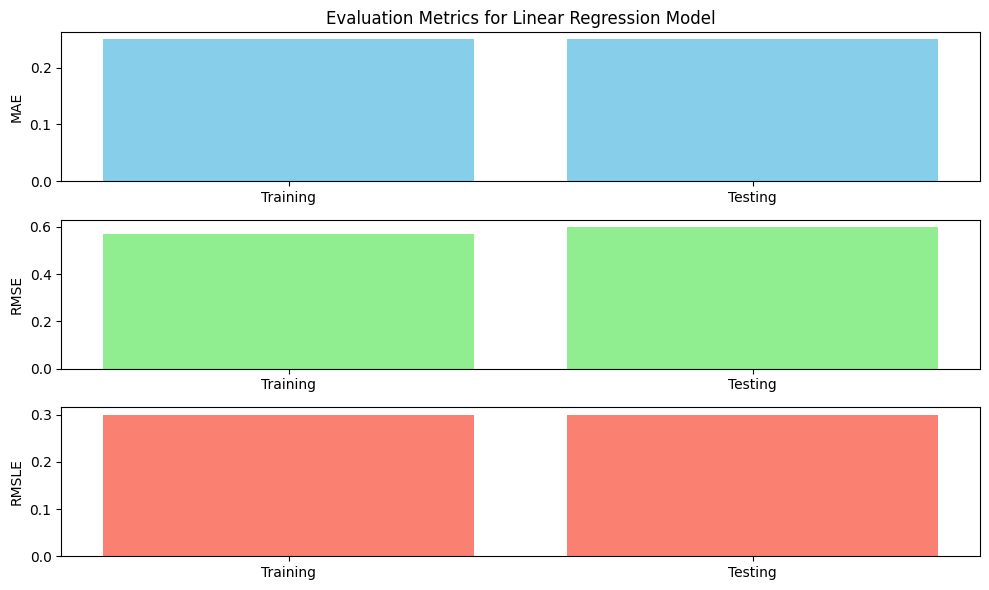

In [253]:


# Define the evaluation metrics for the Linear Regression model
linear_regression_metrics = [
    {'Model': 'Linear Regression', 'Set': 'Training', 'MAE': 0.25, 'RMSE': 0.57, 'RMSLE': 0.30},
    {'Model': 'Linear Regression', 'Set': 'Testing', 'MAE': 0.25, 'RMSE': 0.60, 'RMSLE': 0.30}
]

# Convert the evaluation metrics to a DataFrame
linear_regression_metrics_df = pd.DataFrame(linear_regression_metrics)

# Plotting the evaluation metrics
plt.figure(figsize=(10, 6))

# Plot MAE
plt.subplot(3, 1, 1)
plt.bar(linear_regression_metrics_df['Set'], linear_regression_metrics_df['MAE'], color='skyblue')
plt.ylabel('MAE')
plt.title('Evaluation Metrics for Linear Regression Model')

# Plot RMSE
plt.subplot(3, 1, 2)
plt.bar(linear_regression_metrics_df['Set'], linear_regression_metrics_df['RMSE'], color='lightgreen')
plt.ylabel('RMSE')

# Plot RMSLE
plt.subplot(3, 1, 3)
plt.bar(linear_regression_metrics_df['Set'], linear_regression_metrics_df['RMSLE'], color='salmon')
plt.ylabel('RMSLE')

plt.tight_layout()
plt.show()


## 2. XGBoost Model

In [254]:
# 2. Convert categorical columns to numeric using one-hot encoding
sgb_df = pd.get_dummies(sgb_df, columns=['month_name', 'day_name'])




In [255]:
# 3. Splitting the Data
X = sgb_df.drop(columns=['sales'])
y = sgb_df['sales']




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Building an XGBoost Model
# Initialize XGBoost model
model = XGBRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)



In [ ]:
# Making predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)



In [ ]:
# 5. Evaluating the Model
# Calculate additional metric: Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Evaluate the model
models = []

# Training set
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmsle_train = rmsle(y_train, y_pred_train)
models.append({'Model': 'XGBoost', 'Set': 'Training', 'MAE': mae_train, 'RMSE': rmse_train, 'RMSLE': rmsle_train})

# Testing set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmsle_test = rmsle(y_test, y_pred_test)
models.append({'Model': 'XGBoost', 'Set': 'Testing', 'MAE': mae_test, 'RMSE': rmse_test, 'RMSLE': rmsle_test})

# Convert models to DataFrame for tabular format
XGBmodels_df = pd.DataFrame(models)

# Display the evaluation metrics
XGBmodels_df

,Model,Set,MAE,RMSE,RMSLE
0,XGBoost,Training,0.05,0.16,0.09
1,XGBoost,Testing,0.06,0.44,0.10


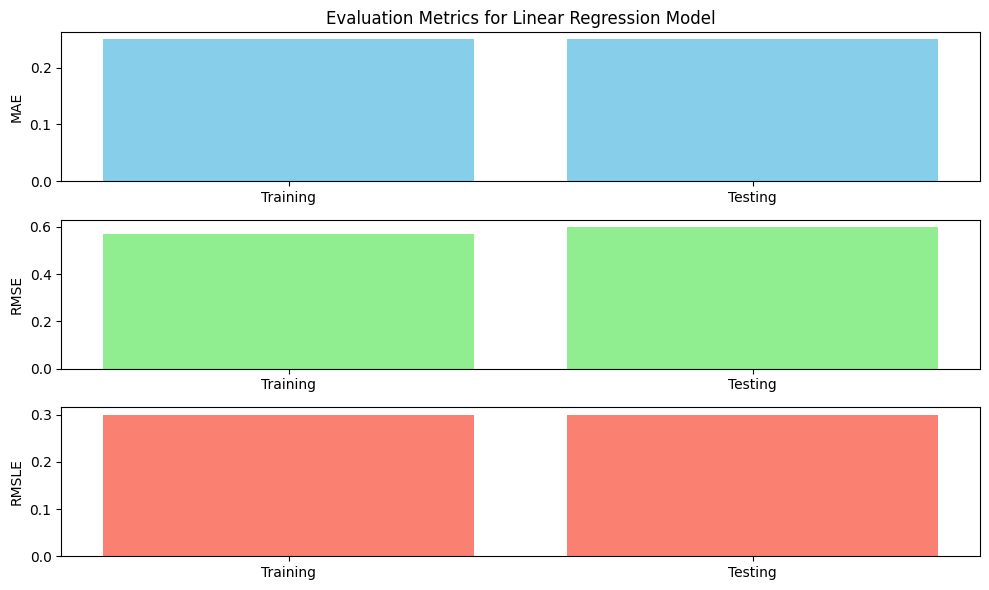

In [ ]:


# Define the evaluation metrics for the Linear Regression model
linear_regression_metrics = [
    {'Model': 'Linear Regression', 'Set': 'Training', 'MAE': 0.25, 'RMSE': 0.57, 'RMSLE': 0.30},
    {'Model': 'Linear Regression', 'Set': 'Testing', 'MAE': 0.25, 'RMSE': 0.60, 'RMSLE': 0.30}
]

# Convert the evaluation metrics to a DataFrame
linear_regression_metrics_df = pd.DataFrame(linear_regression_metrics)

# Plotting the evaluation metrics
plt.figure(figsize=(10, 6))

# Plot MAE
plt.subplot(3, 1, 1)
plt.bar(linear_regression_metrics_df['Set'], linear_regression_metrics_df['MAE'], color='skyblue')
plt.ylabel('MAE')
plt.title('Evaluation Metrics for Linear Regression Model')

# Plot RMSE
plt.subplot(3, 1, 2)
plt.bar(linear_regression_metrics_df['Set'], linear_regression_metrics_df['RMSE'], color='lightgreen')
plt.ylabel('RMSE')

# Plot RMSLE
plt.subplot(3, 1, 3)
plt.bar(linear_regression_metrics_df['Set'], linear_regression_metrics_df['RMSLE'], color='salmon')
plt.ylabel('RMSLE')

plt.tight_layout()
plt.show()


## 3. KNN model

In [ ]:
# 2. Preparing the Data
# Separate features and target
X = sgb_df.drop(columns=['sales'])
y = sgb_df['sales']



In [ ]:
# Identify categorical and numerical columns
categorical_cols = ['month_name', 'day_name']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Ensure categorical columns are included in the list of columns to process
numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

# Create preprocessor with one-hot encoding for categorical columns and standard scaling for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Ensure any other columns are passed through without changes
)

# Create a pipeline that combines preprocessing and KNN model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor())
])



In [ ]:
# 3. Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# 4. Building a KNN Model
# Fit the model on the training data
model_pipeline.fit(X_train, y_train)

In [ ]:


# Making predictions
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

# 5. Evaluating the Model
# Calculate additional metric: Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Evaluate the model
models = []

# Training set
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmsle_train = rmsle(y_train, y_pred_train)
models.append({'Model': 'KNN', 'Set': 'Training', 'MAE': mae_train, 'RMSE': rmse_train, 'RMSLE': rmsle_train})

# Testing set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmsle_test = rmsle(y_test, y_pred_test)
models.append({'Model': 'KNN', 'Set': 'Testing', 'MAE': mae_test, 'RMSE': rmse_test, 'RMSLE': rmsle_test})

# Convert models to DataFrame for tabular format
models_df = pd.DataFrame(models)

# Display the evaluation metrics
print(models_df)

### 4. RandomForestRegressor

In [ ]:

# 2. Preparing the Data
# Separate features and target
X = sgb_df.drop(columns=['sales'])
y = sgb_df['sales']

In [ ]:
# Identify categorical and numerical columns
categorical_cols = ['month_name', 'day_name']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Ensure categorical columns are included in the list of columns to process
numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

# Create preprocessor with one-hot encoding for categorical columns and standard scaling for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Ensure any other columns are passed through without changes
)

# Create a pipeline that combines preprocessing and Random Forest model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# 3. Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# 4. Building a Random Forest Model
# Fit the model on the training data
model_pipeline.fit(X_train, y_train)

ValueError: A given column is not a column of the dataframe

In [ ]:





# Making predictions
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

# 5. Evaluating the Model
# Calculate additional metric: Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Evaluate the model
models = []

# Training set
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmsle_train = rmsle(y_train, y_pred_train)
models.append({'Model': 'Random Forest', 'Set': 'Training', 'MAE': mae_train, 'RMSE': rmse_train, 'RMSLE': rmsle_train})

# Testing set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmsle_test = rmsle(y_test, y_pred_test)
models.append({'Model': 'Random Forest', 'Set': 'Testing', 'MAE': mae_test, 'RMSE': rmse_test, 'RMSLE': rmsle_test})

# Convert models to DataFrame for tabular format
models_df = pd.DataFrame(models)

# Display the evaluation metrics
models_df


### 5.  **ARIMA (AutoRegressive Integrated Moving Average)**

In [ ]:
# 1. Data Preparation
# Convert 'date' column to datetime and set it as index
sgb_df['date'] = pd.to_datetime(sgb_df.index)
sgb_df.set_index('date', inplace=True)

# Aggregating the sales data by date
sales_data = sgb_df[['sales']].resample('D').sum()

In [ ]:
# 2. Splitting the Data
# Splitting into train and test sets (80% train, 20% test)
train_size = int(len(sales_data) * 0.8)
train, test = sales_data[:train_size], sales_data[train_size:]

In [ ]:

# 3. Building an ARIMA Model
# Define the ARIMA model
model = ARIMA(train, order=(5, 1, 0))

# Fit the model on the training data
model_fit = model.fit()

# Making predictions
train_forecast = model_fit.predict(start=train.index[1], end=train.index[-1], typ='levels')
test_forecast = model_fit.predict(start=test.index[0], end=test.index[-1], typ='levels')


LinAlgError: Schur decomposition solver error.

In [ ]:
# 4. Evaluating the Model
# Define a function to calculate RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Evaluate the model
models = []

# Training set
mae_train = mean_absolute_error(train, train_forecast)
rmse_train = mean_squared_error(train, train_forecast, squared=False)
rmsle_train = rmsle(train, train_forecast)
models.append({'Model': 'ARIMA', 'Set': 'Training', 'MAE': mae_train, 'RMSE': rmse_train, 'RMSLE': rmsle_train})

# Testing set
mae_test = mean_absolute_error(test, test_forecast)
rmse_test = mean_squared_error(test, test_forecast, squared=False)
rmsle_test = rmsle(test, test_forecast)
models.append({'Model': 'ARIMA', 'Set': 'Testing', 'MAE': mae_test, 'RMSE': rmse_test, 'RMSLE': rmsle_test})

# Convert models to DataFrame for tabular format
models_df = pd.DataFrame(models)

# Display the evaluation metrics
print(models_df)

# 5. Plotting the Results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(train_forecast.index, train_forecast, label='Train Forecast')
plt.plot(test_forecast.index, test_forecast, label='Test Forecast')
plt.legend()
plt.show()

NameError: name 'train_forecast' is not defined

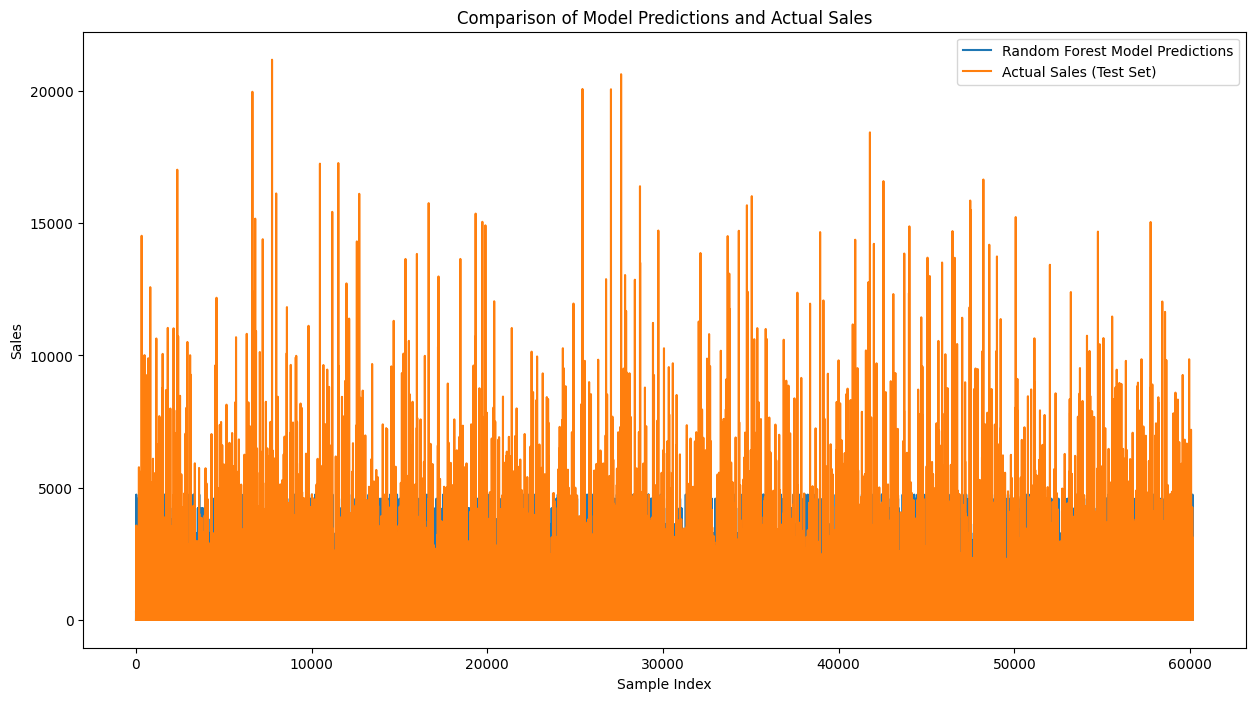

In [ ]:




# Convert y_pred to a DataFrame for plotting
y_pred_df = pd.DataFrame({'sales': y_pred})

# Plot the model predictions and the actual values
plt.plot(y_pred_df['sales'], label='Random Forest Model Predictions')
plt.plot(y_test.values, label='Actual Sales (Test Set)')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.title('Comparison of Model Predictions and Actual Sales')
plt.show()


###  K-Nearest Neighbors Regression (KNN)

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X

,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,year_2013,year_2014,year_2015,year_2016,year_2017
1305170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1302279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2797893,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
62801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
464655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903871,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1332561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1820092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1050125,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
y

1305170    193.00
1302279      0.00
2797893      0.00
62801        1.00
464655       0.00
            ...  
1903871     13.00
1332561      0.00
1820092      3.00
1050125   2324.00
723227    2688.00
Name: sales, Length: 300802, dtype: float64

In [ ]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:

# Train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [ ]:


# Make predictions
y_pred = knn_model.predict(X_test_scaled)

In [ ]:
# Convert y_pred to a DataFrame for plotting
y_pred_df = pd.DataFrame({'sales': y_pred})

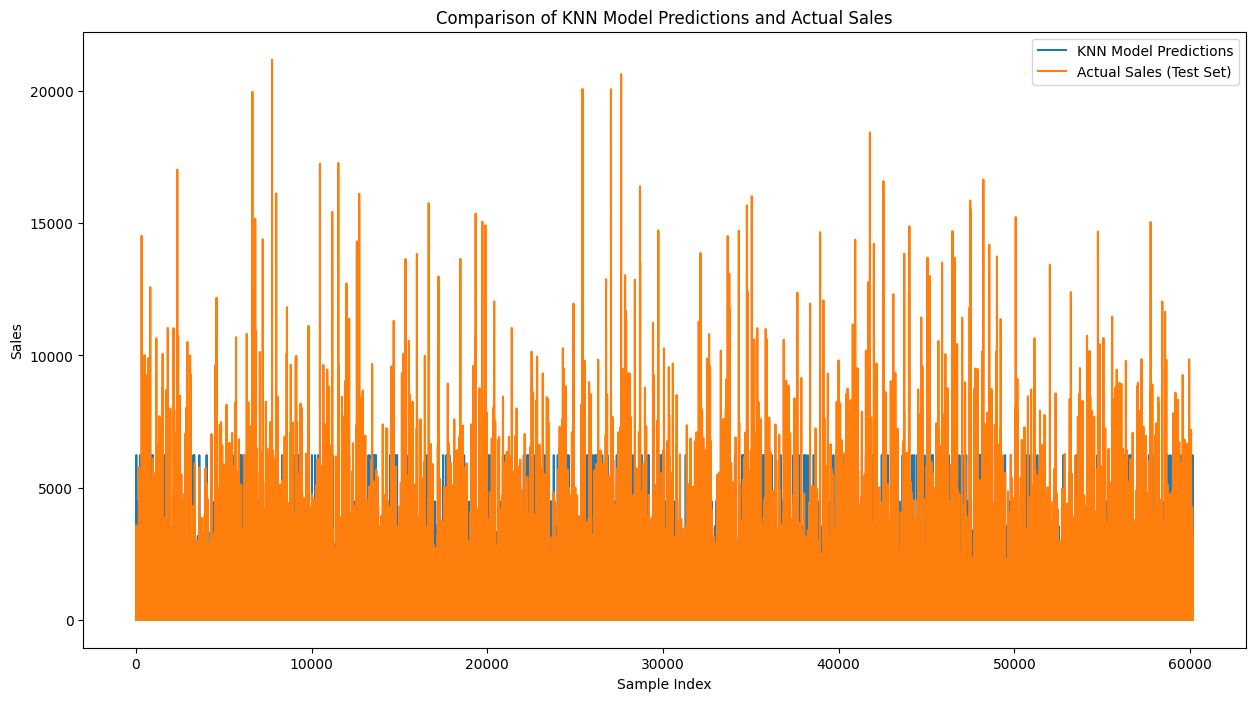

In [ ]:

# Plot the model predictions and the actual values
plt.plot(y_pred_df['sales'], label='KNN Model Predictions')
plt.plot(y_test.values, label='Actual Sales (Test Set)')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.title('Comparison of KNN Model Predictions and Actual Sales')
plt.show()


In [ ]:
df = complete_df.copy